In [188]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import StandardScaler
import os
from ast import literal_eval
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from plotly import express as px
import requests

In [189]:
def create_binary_features(df, name_of_column, num_of_top=25):

    list_of_columns = list(df[name_of_column].apply(lambda x: [idx['name'] for idx in x] if x != {} else []).values)
    top_values = [m[0] for m in Counter([i for j in list_of_columns for i in j]).most_common(num_of_top)]
    try:
        new_name = name_of_column.split('_')[1]
    except:
        new_name = name_of_column.split('_')[0]

    df["num_"+new_name] = df[name_of_column].apply(lambda x: len(x) if x != {} else 0)
    df["all_"+new_name] = df[name_of_column].apply(lambda x: ' '.join(sorted([idx['name'] for idx in x])) if x != {} else '')
    for value in top_values:
        df[name_of_column + "_" + value] = df["all_"+new_name].apply(lambda x: 1 if value in x else 0)
    return df, list_of_columns

In [190]:
def create_df_for_pie(list_of_values, column_name, most_common_num=25):
    count_values = Counter([value for sample in list_of_values for value in sample]).most_common(most_common_num)
    df = pd.DataFrame()
    df[column_name] = [count_values[idx][0] for idx in range(len(count_values))]
    df["count"] = [count_values[idx][1] for idx in range(len(count_values))]
    return df

## Import dataset and primary information

In [198]:
url_train = "https://drive.google.com/u/0/uc?id=1bdEFroCXSVJv9LL31j8SmYciLA-aJW-J&export=download"
url_test = "https://drive.google.com/u/0/uc?id=1qiDUiLoxuUev57Vl8XC5g8afF6OVrkjW&export=download"

In [199]:
df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)

Let`s make some data exploration.

In [200]:
df_train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [201]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

Reevaluating data, because we have some non-standart entities

In [49]:
df_train['genres']

0                          [{'id': 35, 'name': 'Comedy'}]
1       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                           [{'id': 18, 'name': 'Drama'}]
3       [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4       [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
                              ...                        
2995    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2996    [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...
2997    [{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...
2998    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2999    [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...
Name: genres, Length: 3000, dtype: object

In [50]:
columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else literal_eval(x))
    return df
        
df_train = text_to_dict(df_train)
df_test = text_to_dict(df_test)

### Genres

Creating df_genre for visualization

In [51]:
list_of_genres = list(df_train['genres'].apply(lambda x: [idx['name'] for idx in x] if x != {} else []).values)
count_genres = Counter([genre for sample in list_of_genres for genre in sample]).most_common()
df_genre = pd.DataFrame()
df_genre["genre"] = [count_genres[idx][0] for idx in range(len(count_genres))]
df_genre["count"] = [count_genres[idx][1] for idx in range(len(count_genres))]

In [52]:
df_genre

,genre,count
0,Drama,1531
1,Comedy,1028
2,Thriller,789
3,Action,741
4,Romance,571
5,Crime,469
6,Adventure,439
7,Horror,301
8,Science Fiction,290
9,Family,260


This pie chart and all following infographics are interactive, you can play with them if you want to see different features.  

In [53]:
fig = px.pie(df_genre, values='count', names='genre', title='Genres in our dataset')
fig.show()

In [54]:
# That function create columns with genres like numerical features
def create_genres_columns(df):
    df['num_genres'] = df['genres'].apply(lambda x: len(x) if x != {} else 0)
    df['all_genres'] = df['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
    for g in top_genres:
        df['genre_' + g] = df['all_genres'].apply(lambda x: 1 if g in x else 0)
    return df

In [55]:
df_train = create_genres_columns(df_train)
df_test = create_genres_columns(df_test)

In [56]:
df_train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,4,Comedy Drama Family Romance,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,2,Drama Thriller,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,2,Action Thriller,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


We transferred all valuable information and binarized it for training. Now we can drop column 'genres'.

In [57]:
df_train = df_train.drop(['genres'], axis=1)
df_test = df_test.drop(['genres'], axis=1)

### Production studios

In this section, we will look at the companies that make films and the statistics of the films they have made. 

In [58]:
df_train, list_of_companies = create_binary_features(df_train, "production_companies", num_of_top=30)
df_test, list_of_companies = create_binary_features(df_test, "production_companies", num_of_top=30)

In [59]:
df_companies = create_df_for_pie(list_of_companies, "company", most_common_num=20)

In [60]:
fig = px.pie(df_companies[:20], values='count', names='company', title='Top 20 companies in our dataset')
fig.show()

We dropped column production_companies and create new binary columns, because data in column production_companies has dtype dict and is not suitable for training 

In [61]:
df_train = df_train.drop(['production_companies', 'all_companies'], axis=1)
df_test = df_test.drop(['production_companies', 'all_companies'], axis=1)

### Contries production

In [62]:
df_test, list_of_countries = create_binary_features(df_test, "production_countries", num_of_top=25)
df_train, list_of_countries = create_binary_features(df_train, "production_countries", num_of_top=25)

In [63]:
df_countries = create_df_for_pie(list_of_countries, "country", most_common_num=20)

In [64]:
fig = px.pie(df_countries[:10], values='count', names='country', title='Top 10 countries in our dataset')
fig.show()

In [65]:
df_train = df_train.drop(['production_countries', 'all_countries'], axis=1)
df_test = df_test.drop(['production_countries', 'all_countries'], axis=1)

### Top languages

In [66]:
df_test, list_of_languages = create_binary_features(df_test, "spoken_languages", num_of_top=25)
df_train, list_of_languages = create_binary_features(df_train, "spoken_languages", num_of_top=25)

In [67]:
df_languages = create_df_for_pie(list_of_languages, "language", most_common_num=20)

In [68]:
df_languages = df_languages.drop(9)

In [69]:
fig = px.pie(df_languages[:10], values='count', names='language', title='Top 10 languages in our dataset')
fig.show()

In [70]:
df_train = df_train.drop(['spoken_languages', 'all_languages'], axis=1)
df_test = df_test.drop(['spoken_languages', 'all_languages'], axis=1)

### Keywords

Let`s see which keywords are most often in our film descriptions. We will show them in wordcloud format.

In [71]:
df_test, list_of_keywords = create_binary_features(df_test, "Keywords", num_of_top=30)
df_train, list_of_keywords = create_binary_features(df_train, "Keywords", num_of_top=30)

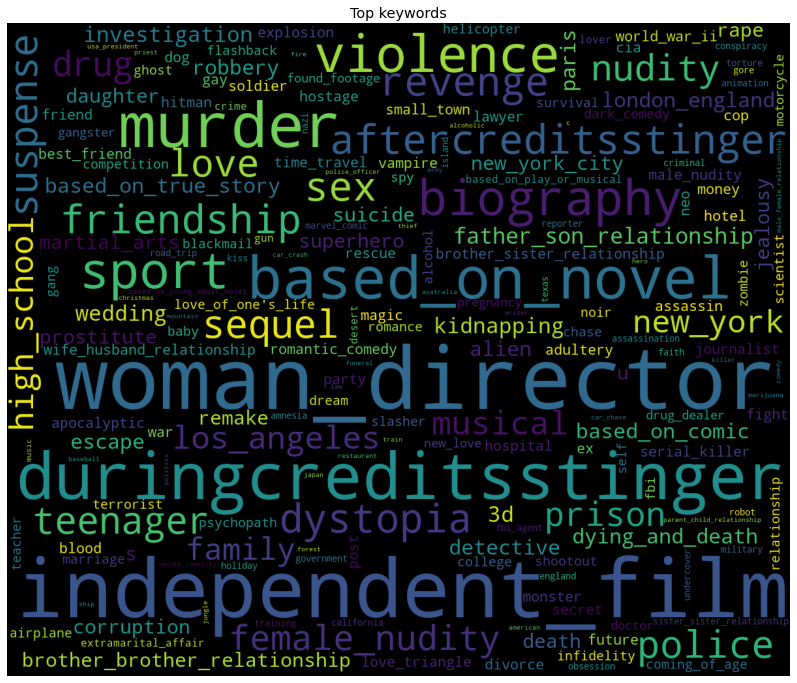

In [72]:
plt.figure(figsize = (22, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

Based on this info we can assume that this dataset mostly contains films made by women and there are many independent, non commercial films. 

In [73]:
df_train = df_train.drop(['Keywords', 'all_Keywords'], axis=1)
df_test = df_test.drop(['Keywords', 'all_Keywords'], axis=1)

### Top cast of actors

Now we are going to see which actors were screened in our films more often than others. 

In [74]:
def create_cast_features(df):

    list_of_cast_names = list(df['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
    list_of_cast_characters = list(df['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)

    df['num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)
    top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
    for g in top_cast_names:
        df['cast_name_' + g] = df['cast'].apply(lambda x: 1 if g in str(x) else 0)
    df['genders_0_cast'] = df['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
    df['genders_1_cast'] = df['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
    df['genders_2_cast'] = df['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
    top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
    for g in top_cast_characters:
        df['cast_character_' + g] = df['cast'].apply(lambda x: 1 if g in str(x) else 0)
    return df, list_of_cast_characters, list_of_cast_names

In [75]:
df_test, list_of_cast_characters, list_of_cast_names = create_cast_features(df_test)
df_train, list_of_cast_characters, list_of_cast_names = create_cast_features(df_train)

In [76]:
def create_binary_features(df, name_of_column, num_of_top=25):

    list_of_columns = list(df[name_of_column].apply(lambda x: [idx['name'] for idx in x] if x != {} else []).values)
    top_values = [m[0] for m in Counter([i for j in list_of_columns for i in j]).most_common(num_of_top)]
    try:
        new_name = name_of_column.split('_')[1]
    except:
        new_name = name_of_column.split('_')[0]

    df["num_"+new_name] = df[name_of_column].apply(lambda x: len(x) if x != {} else 0)
    df["all_"+new_name] = df[name_of_column].apply(lambda x: ' '.join(sorted([idx['name'] for idx in x])) if x != {} else '')
    for value in top_values:
        df[name_of_column + "_" + value] = df["all_"+new_name].apply(lambda x: 1 if value in x else 0)
    return df, list_of_columns

In [77]:
df_cast = create_df_for_pie(list_of_cast_names, "cast", most_common_num=15)

In [78]:
df_cast

,cast,count
0,Samuel L. Jackson,30
1,Robert De Niro,30
2,Morgan Freeman,27
3,J.K. Simmons,25
4,Bruce Willis,25
5,Liam Neeson,25
6,Susan Sarandon,25
7,Bruce McGill,24
8,John Turturro,24
9,Forest Whitaker,23


That is quite interesting result, especially if we would take into account that 'independent_film' were in top 3 biggest word in wordcloud. Quite many famous stars are into these films!

In [79]:
fig = px.pie(df_cast, values='count', names='cast', title='Top 15 actors in our dataset')
fig.show()

### Top characters

Let us take a look at distribution of characters` features.

In [80]:
df_char = create_df_for_pie(list_of_cast_characters, "role", most_common_num=16)

In [81]:
df_char = df_char[1:]

In [82]:
df_char

,role,count
1,Himself,610
2,Herself,155
3,Dancer,144
4,Additional Voices (voice),100
5,Doctor,77
6,Reporter,70
7,Waitress,69
8,Nurse,65
9,Bartender,55
10,Jack,54


In [83]:
fig = px.pie(df_char, values='count', names='role', title='Top 15 features in our dataset')
fig.show()

### Cast gender division 

We live in a modern world and we must also take into account the gender of the actor. 

In [84]:
list_of_cast_genders = list(df_train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)

In [85]:
df_cast_gender = create_df_for_pie(list_of_cast_genders, "gender", most_common_num=3)

In [86]:
df_cast_gender.gender[df_cast_gender.gender==2] = "Male"
df_cast_gender.gender[df_cast_gender.gender==1] = "Female"
df_cast_gender.gender[df_cast_gender.gender==0] = "Unknown"

C:\Anaconda\envs\p3.7\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\envs\p3.7\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [87]:
df_cast_gender

,gender,count
0,Male,27949
1,Unknown,20329
2,Female,13533


In [88]:
fig = px.pie(df_cast_gender, values='count', names='gender', title='Top gender of actors in our dataset')
fig.show()

In [89]:
df_train = df_train.drop(['cast'], axis=1)
df_test = df_test.drop(['cast'], axis=1)

### Important crew like Music Composer, Producers and Casting Producers

In [90]:
list_of_crew_names = list(df_train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [91]:
df_crew_names = create_df_for_pie(list_of_crew_names, "name", most_common_num=20)

In [92]:
fig = px.pie(df_crew_names, values='count', names='name', title='Top crew members in our dataset')
fig.show()

In [93]:
list_of_crew_jobs = list(df_train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
df_crew_jobs = create_df_for_pie(list_of_crew_jobs, "job", most_common_num=20)

In [94]:
fig = px.pie(df_crew_jobs, values='count', names='job', title='Top jobs in our dataset')
fig.show()

In [95]:
list_of_crew_genders = list(df_train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
df_crew_gender = create_df_for_pie(list_of_crew_genders, "gender", most_common_num=20)

In [96]:
df_crew_gender.gender[df_crew_gender.gender==2] = "Male"
df_crew_gender.gender[df_crew_gender.gender==1] = "Female"
df_crew_gender.gender[df_crew_gender.gender==0] = "Unknown"

C:\Anaconda\envs\p3.7\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\envs\p3.7\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
fig = px.pie(df_crew_gender, values='count', names='gender', title='Gender of crew members in our dataset')
fig.show()

As we can see, our data is imperfect.

In [98]:
list_of_crew_departments = list(df_train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
df_crew_names = create_df_for_pie(list_of_crew_departments, "department", most_common_num=15)

In [99]:
fig = px.pie(df_crew_names, values='count', names='department', title='Departments of crew in our dataset')
fig.show()

In [100]:
def create_features_for_crew(df):
    df['num_crew'] = df['crew'].apply(lambda x: len(x) if x != {} else 0)
    top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
    for g in top_crew_names:
        df['crew_name_' + g] = df['crew'].apply(lambda x: 1 if g in str(x) else 0)
    df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
    df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
    df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
    top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
    for j in top_crew_jobs:
        df['jobs_' + j] = df['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
    top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
    for j in top_crew_departments:
        df['departments_' + j] = df['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j]))
    return df

In [101]:
df_train = create_features_for_crew(df_train)
df_test = create_features_for_crew(df_test)

In [102]:
df_test = create_features_for_crew(df_test)

In [103]:
df_test.head()

,id,belongs_to_collection,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,crew,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_companies_Warner Bros.,production_companies_Universal Pictures,production_companies_Paramount Pictures,production_companies_Twentieth Century Fox Film Corporation,production_companies_Columbia Pictures,production_companies_Metro-Goldwyn-Mayer (MGM),production_companies_New Line Cinema,production_companies_Touchstone Pictures,production_companies_Walt Disney Pictures,production_companies_Canal+,production_companies_Columbia Pictures Corporation,production_companies_TriStar Pictures,production_companies_Relativity Media,production_companies_Miramax Films,production_companies_United Artists,production_companies_Village Roadshow Pictures,production_companies_DreamWorks SKG,production_companies_Regency Enterprises,production_companies_Amblin Entertainment,production_companies_Lionsgate,production_companies_Fox Searchlight Pictures,production_companies_Summit Entertainment,production_companies_StudioCanal,production_companies_Dimension Films,production_companies_Working Title Films,production_companies_Orion Pictures,production_companies_Imagine Entertainment,production_companies_Dune Entertainment,production_companies_Film4,production_companies_Hollywood Pictures,num_countries,production_countries_United States of America,production_countries_United Kingdom,production_countries_France,production_countries_Germany,production_countries_Canada,production_countries_India,production_countries_Japan,production_countries_Italy,production_countries_Australia,production_countries_Spain,production_countries_Russia,production_countries_China,production_countries_Hong Kong,production_countries_Belgium,production_countries_Ireland,production_countries_South Korea,production_countries_Sweden,production_countries_Netherlands,production_countries_Denmark,production_countries_Mexico,production_countries_New Zealand,production_countries_Switzerland,production_countries_Czech Republic,production_countries_Norway,production_countries_South Africa,num_languages,spoken_languages_English,spoken_languages_Français,spoken_languages_Español,spoken_languages_Deutsch,spoken_languages_Pусский,spoken_languages_Italiano,spoken_languages_日本語,spoken_languages_हिन्दी,spoken_languages_普通话,spoken_languages_,spoken_languages_العربية,spoken_languages_Português,spoken_languages_广州话 / 廣州話,spoken_languages_Polski,spoken_languages_Latin,spoken_languages_한국어/조선말,spoken_languages_Magyar,spoken_languages_Český,spoken_languages_ภาษาไทย,spoken_languages_svenska,spoken_languages_עִבְרִית,spoken_languages_தமிழ்,spoken_languages_Türkçe,spoken_languages_ελληνικά,spoken_languages_Română,num_Keywords,Keywords_woman director,Keywords_independent film,Keywords_duringcreditsstinger,Keywords_based on novel,Keywords_murder,Keywords_violence,Keywords_love,Keywords_revenge,Keywords_sex,Keywords_aftercreditsstinger,Keywords_biography,Keywords_musical,Keywords_friendship,Keywords_nudity,Keywords_police,Keywords_sport,Keywords_dystopia,Keywords_suspense,Keywords_sequel,Keywords_teenager,Keywords_los angeles,Keywords_drug,Keywords_female nudity,Keywords_new york,Keywords_3d,Keywords_world war ii,Keywords_alien,Keywords_family,Keywords_prison,Keywords_high school,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Steve Buscemi,cast_name_Bruce Willis,cast_name_Morgan Freeman,cast_name_Robin Williams,cast_name_Sylvester Stallone,cast_name_Johnny Depp,cast_name_Willem Dafoe,cast_name_Julianne Moore,cast_name_Nicolas Cage,cast_name_Liam Neeson,cast_name_Christopher Walken,cast_name_Ben Stiller,cast_name_Matt Damon,genders_0_cast,genders_1_cast,genders_2_cast,cast_c

In [104]:
df_train = df_train.drop(['crew'], axis=1)
df_test = df_test.drop(['crew'], axis=1)

# Exploration Data Analysis

In [105]:
# Count of missing values in each column in train:
df_train.isna().sum()

id                               0
belongs_to_collection            0
budget                           0
homepage                      2054
imdb_id                          0
                              ... 
departments_Directing            0
departments_Editing              0
departments_Visual Effects       0
departments_Lighting             0
departments_Actors               0
Length: 227, dtype: int64

## Plot Budget vs Revenue

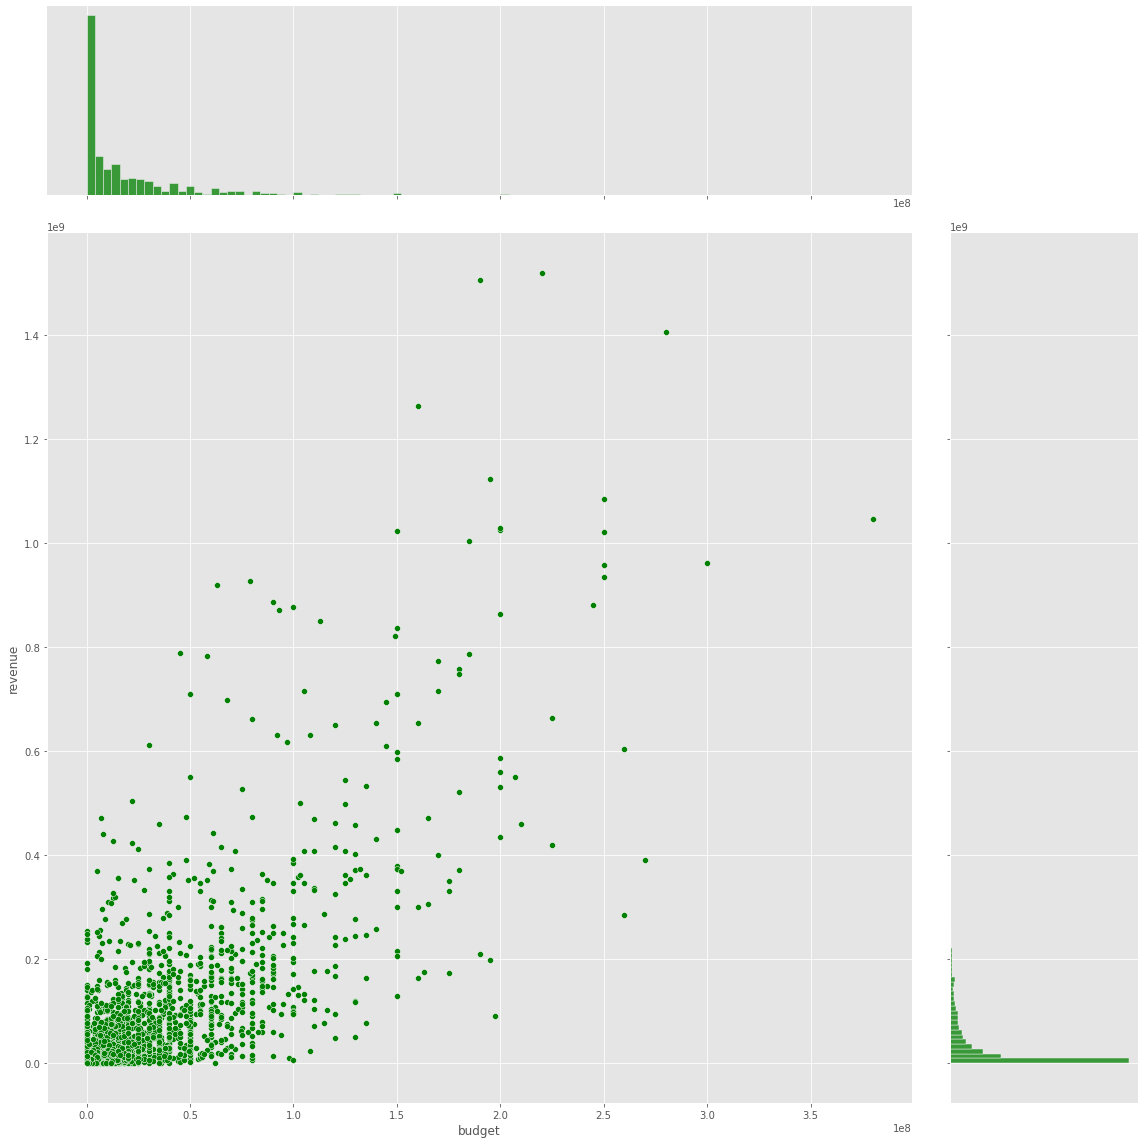

In [106]:
sns.jointplot(x="budget", y="revenue", data=df_train, height=16, ratio=4, color="g")
plt.show()

We can see a positive correlation between budget and revenue.

## Plot popularity vs revenue

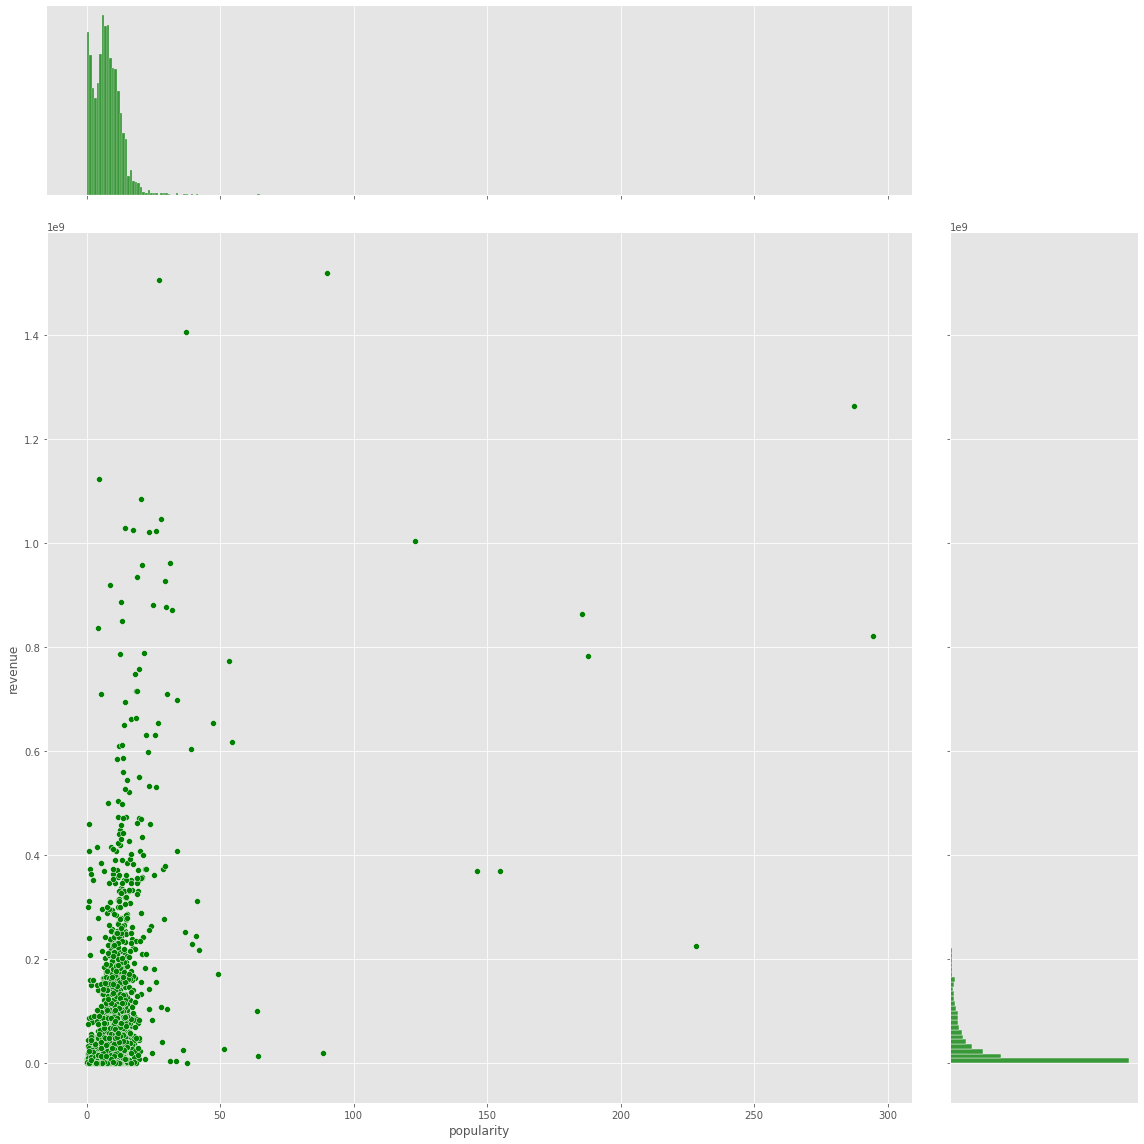

In [107]:
sns.jointplot(x="popularity", y="revenue", data=df_train, height=16, ratio=4, color="g")
plt.show()

This is quite interesting. As we can observe, high value of revenue does not mean that film is also popular.

## Plot runtime vs revenue

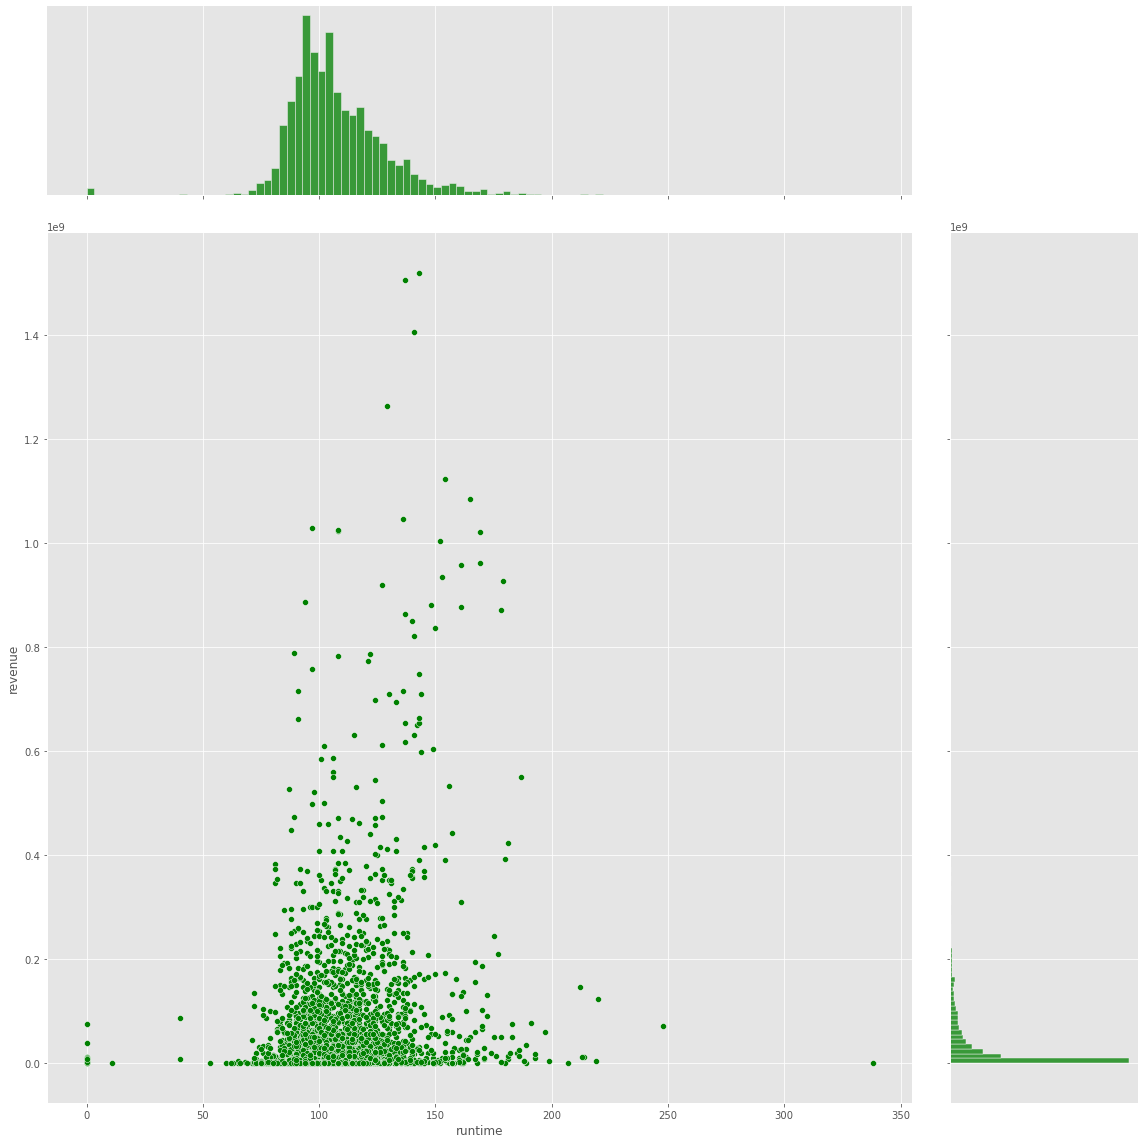

In [108]:
sns.jointplot(x="runtime", y="revenue", data=df_train, height=16, ratio=4, color="g")
plt.show()

## Revenue (Target Variable) Distribution

In [109]:
df_train.revenue.describe()

count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64

C:\Anaconda\envs\p3.7\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



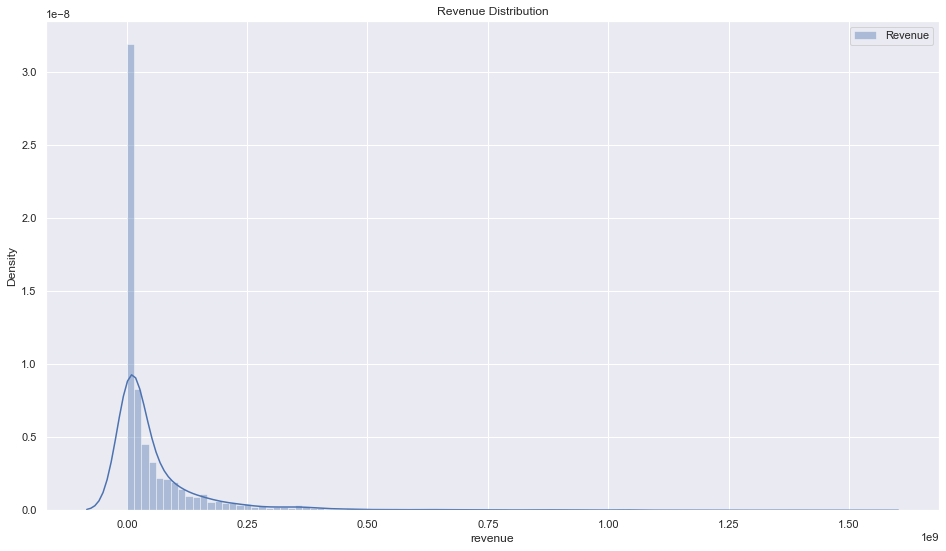

In [110]:
plt.figure(figsize=(16,9))
sns.set()
sns.distplot(df_train.revenue, label="Revenue", bins=100)
plt.title("Revenue Distribution") 
plt.legend()

Looks like a power law. There are a lot of films with low revenue and it`s volume is getting lower and lower with revenue growth.

C:\Anaconda\envs\p3.7\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



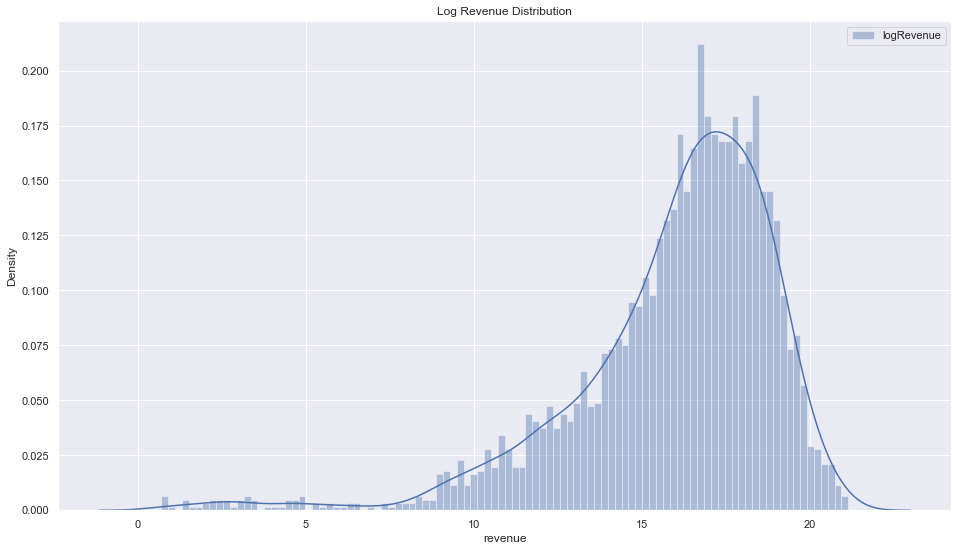

In [111]:
plt.figure(figsize=(16,9))
sns.set()
sns.distplot(np.log1p(df_train['revenue']), label="logRevenue", bins=100)
plt.title("Log Revenue Distribution") 
plt.legend()

## Calendar of release dates.

Let`s take a look at film distribution by release year, month and day

In [112]:
df_train[['release_month','release_day','release_year']]=df_train['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
# Some rows have 4 digits of year instead of 2, that's why I am applying (train['release_year'] < 100) this condition
df_train.loc[(df_train['release_year'] <= 19) & (df_train['release_year'] < 100), "release_year"] += 2000
df_train.loc[(df_train['release_year'] > 19)  & (df_train['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(df_train['release_date']) 
df_train['release_dayofweek'] = releaseDate.dt.dayofweek
df_train['release_quarter'] = releaseDate.dt.quarter

C:\Anaconda\envs\p3.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



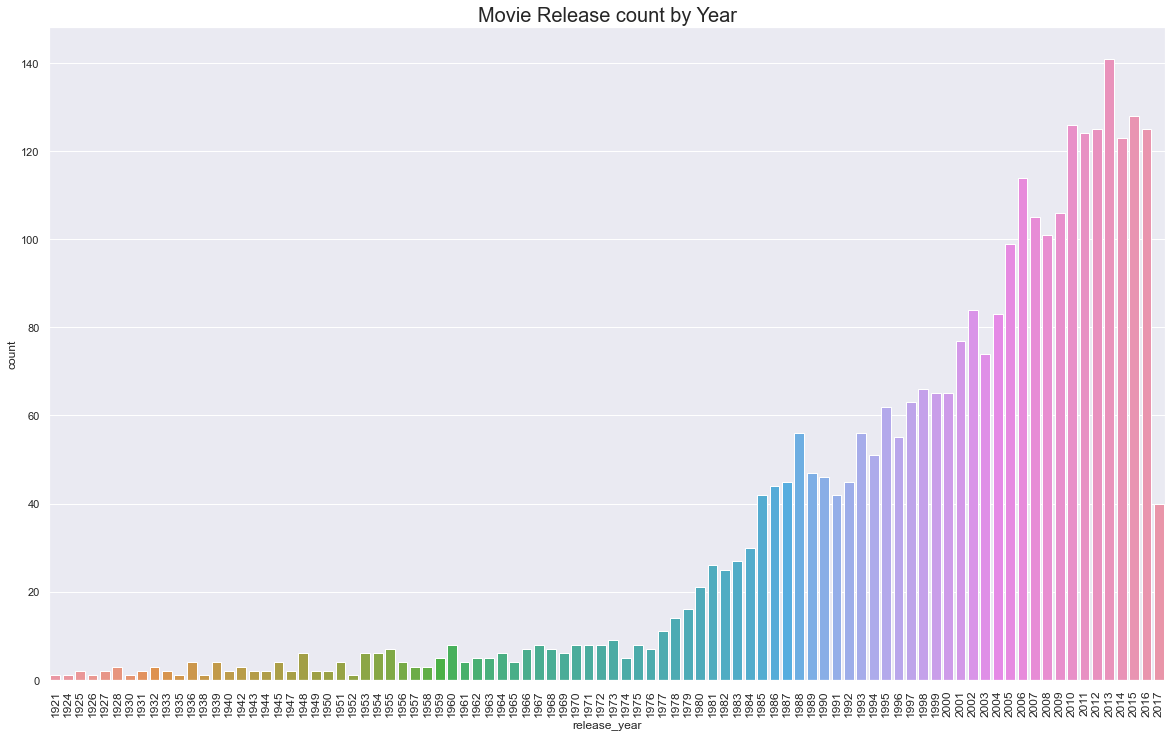

In [113]:
plt.figure(figsize=(20,12))
sns.countplot(df_train['release_year'].sort_values())
plt.title("Movie Release count by Year",fontsize=20)
loc, labels = plt.xticks()
plt.xticks(fontsize=12,rotation=90)
plt.show()

As years go by number of released films increases. We can see quite a surge in film production starting from 1977. \
Also, there is not that many films released in 2017, but it`s because of imperfection of data. 

C:\Anaconda\envs\p3.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



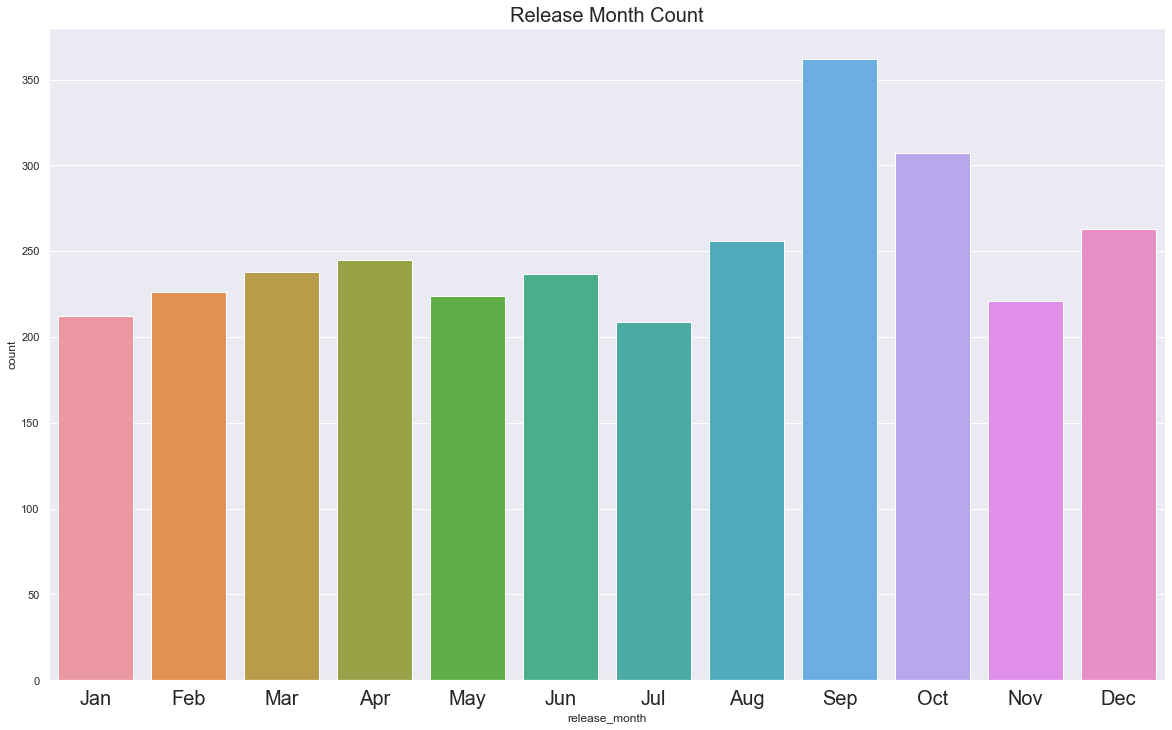

In [114]:
plt.figure(figsize=(20,12))
sns.countplot(df_train['release_month'].sort_values())
plt.title("Release Month Count",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

There are a lot of films released in September. We can assume that filmmakers are doing that because there are a lot of families going on summer vacation and usually they are coming back at September, when school is starting.  

C:\Anaconda\envs\p3.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



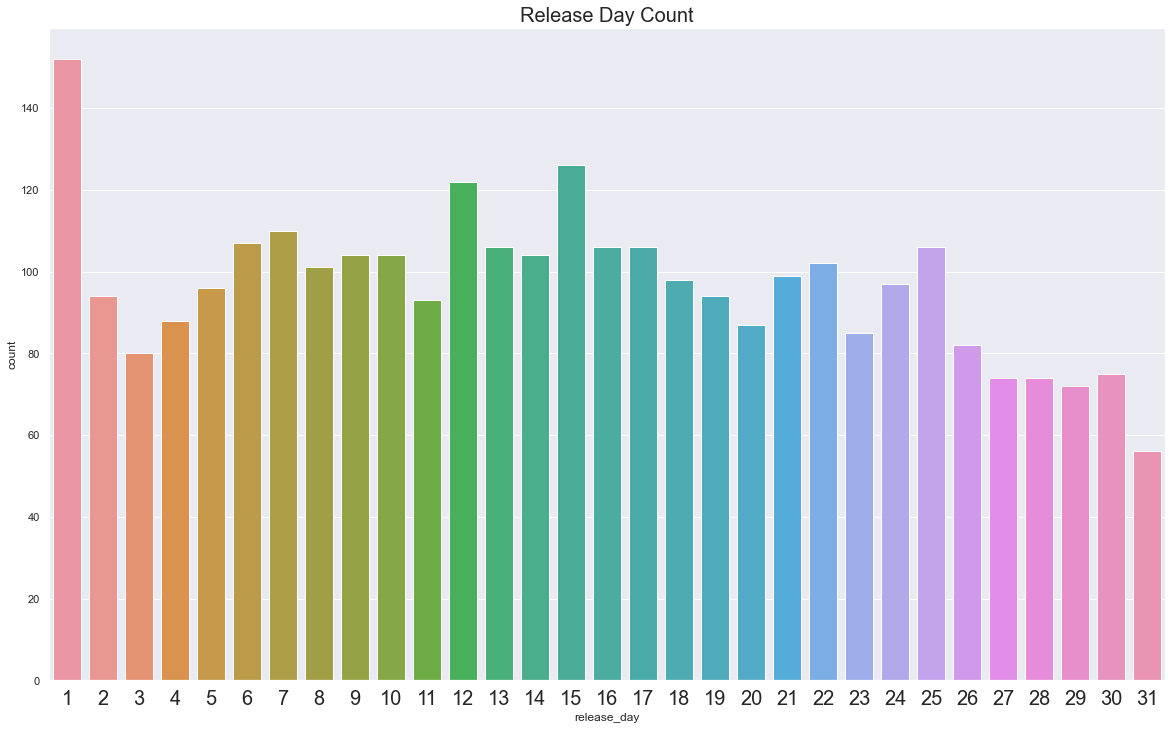

In [115]:
plt.figure(figsize=(20,12))
sns.countplot(df_train['release_day'].sort_values())
plt.title("Release Day Count",fontsize=20)
plt.xticks(fontsize=20)
plt.show()

Maybe it`s just convinient and looks cool at posters to release your film at the start of the month.

C:\Anaconda\envs\p3.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



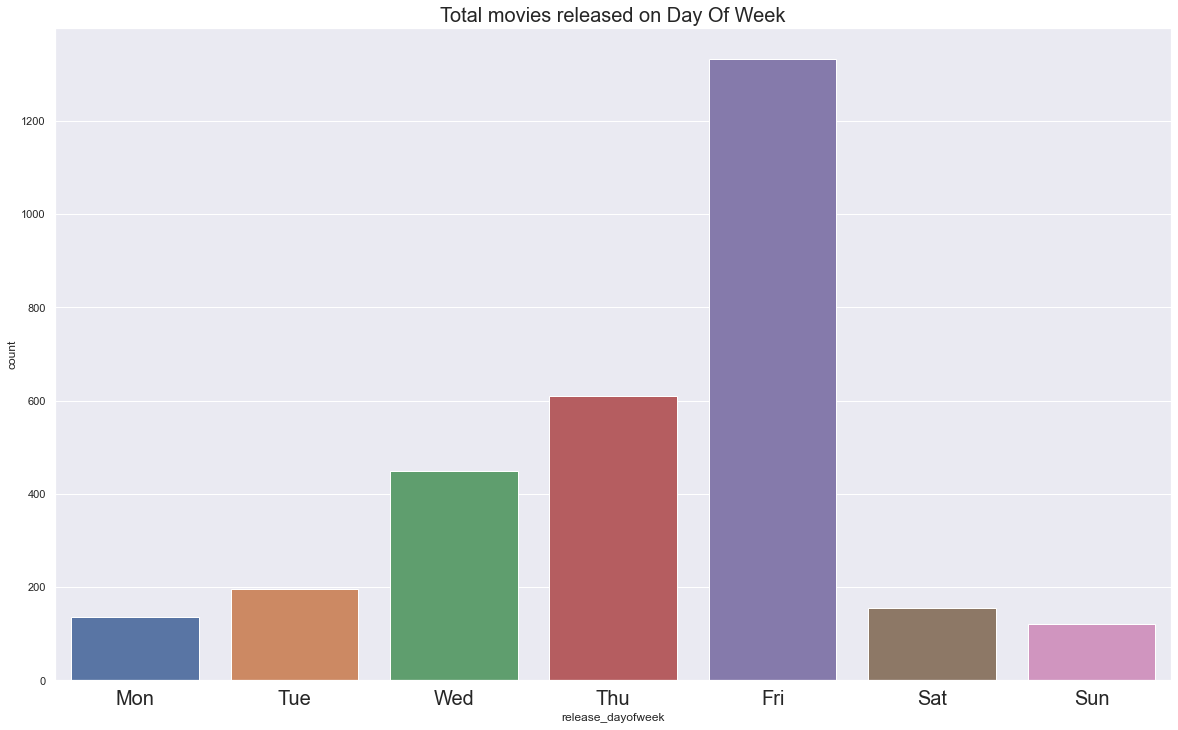

In [116]:
plt.figure(figsize=(20,12))
sns.countplot(df_train['release_dayofweek'].sort_values())
plt.title("Total movies released on Day Of Week",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

Who wouldn`t want to go to the cinema at Friday night, when your long-awaited film is released. 

C:\Anaconda\envs\p3.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



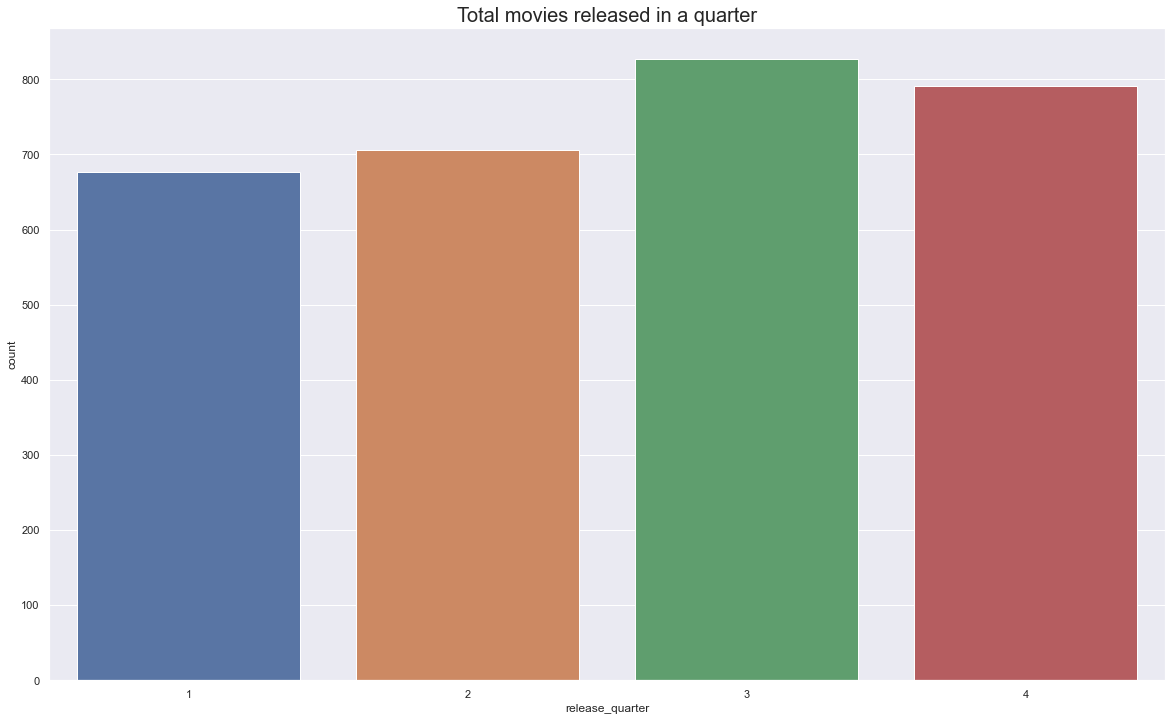

In [117]:
plt.figure(figsize=(20,12))
sns.countplot(df_train['release_quarter'].sort_values())
plt.title("Total movies released in a quarter", fontsize=20)
plt.show()

It checks out with our previous graphics

## Plot Release Year vs Revenue.


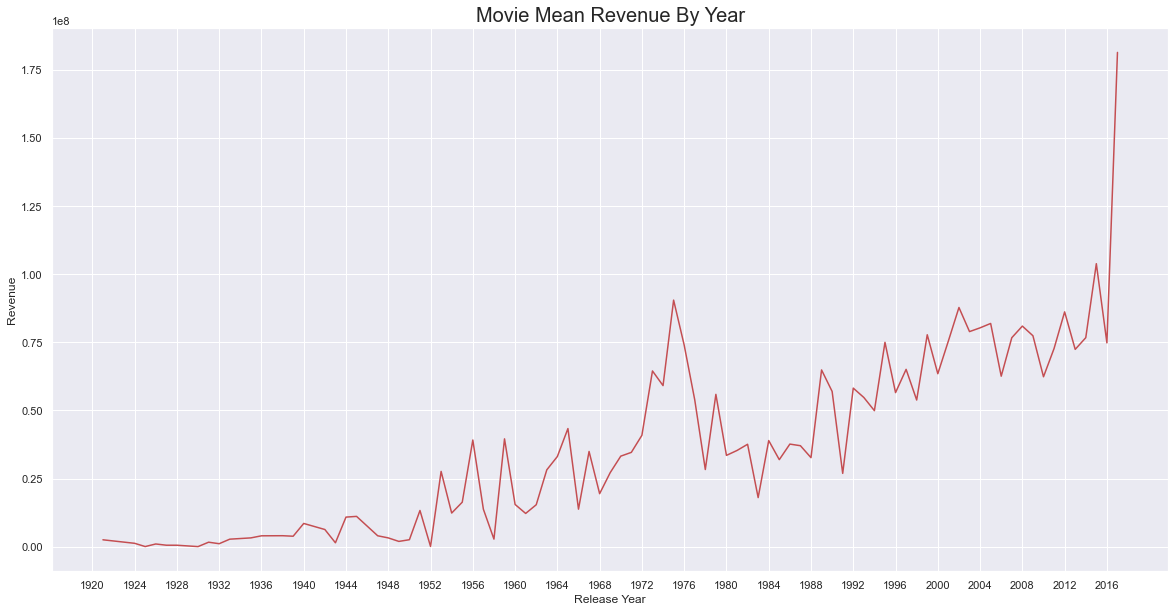

In [118]:
df_train.groupby("release_year")["revenue"].aggregate('mean').plot(figsize=(20,10),color="r")
plt.xticks(np.arange(1920,2017,4))
plt.xlabel("Release Year")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Year",fontsize=20)
plt.show()

There were definitely a surge in cinema industry in 1970s. The surge after 2016 happened because of lack of data in 2017. There are a lot of big revenue films with not enough data to balance it out.

## Another interesting metrics

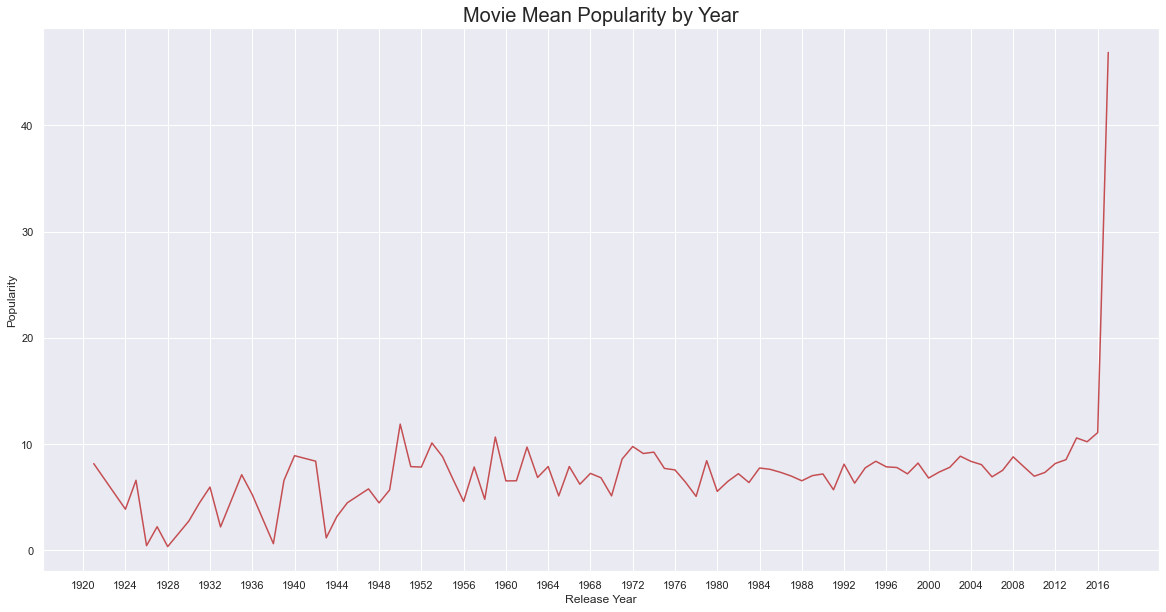

In [119]:
df_train.groupby("release_year")["popularity"].aggregate('mean').plot(figsize=(20,10),color="r")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Popularity")
plt.title("Movie Mean Popularity by Year",fontsize=20)
plt.show()

As we can see, people were not very interested in films in the start and the end of the WW2. We can assume that in the time of war people tried to escape reality and boost morale.

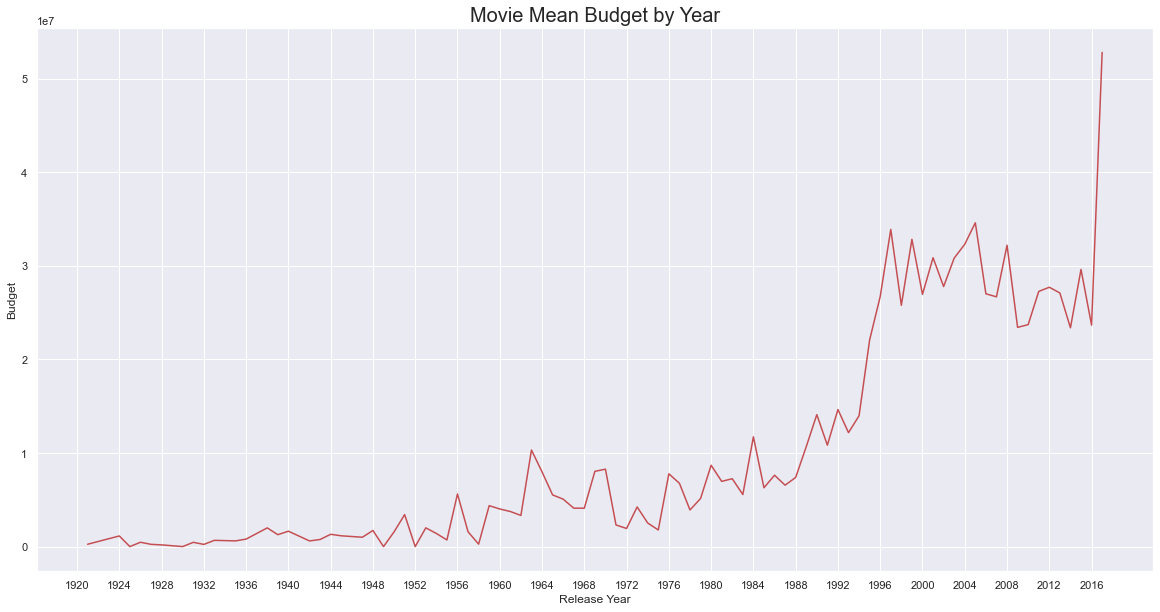

In [120]:
df_train.groupby("release_year")["budget"].aggregate('mean').plot(figsize=(20,10),color="r")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Budget")
plt.title("Movie Mean Budget by Year",fontsize=20)
plt.show()

In 90s movie industry really bloomed.

## Add ratings for films

Let's add some additional features, as popularity, ratings and total votes. It is not that fair, but we don't have to predict revenue exactly before release, so we can add them. But if we would have a task to predict film revenue based only on film characteristics, we couldn't add them.

In [202]:
url_train_add =  'https://drive.google.com/u/0/uc?id=1ea4I-flcZjjkNMqiBfzuv8R9c9yCMNfU&export=download'
url_test_add = 'https://drive.google.com/u/0/uc?id=10oY0YPcdv58DdkN65tZlzEQ6SC6rNYLJ&export=download'

trainAdditionalFeatures = pd.read_csv('TrainAdditionalFeatures.csv')
testAdditionalFeatures = pd.read_csv('TestAdditionalFeatures.csv')

df_train = pd.concat([df_train, trainAdditionalFeatures], axis=1)
df_test = pd.concat([df_test, trainAdditionalFeatures], axis=1)

### Missing rating values

In [122]:
print("Missing rating in Train set", df_train['rating'].isna().sum())
print("Missing total Votes in Train set", df_train['totalVotes'].isna().sum())
print("")
print("Missing rating in Test set", df_test['rating'].isna().sum())
print("Missing total Votes in Test set", df_test['totalVotes'].isna().sum())

Missing rating in Train set 118
Missing total Votes in Train set 118

Missing rating in Test set 1516
Missing total Votes in Test set 1516


C:\Anaconda\envs\p3.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



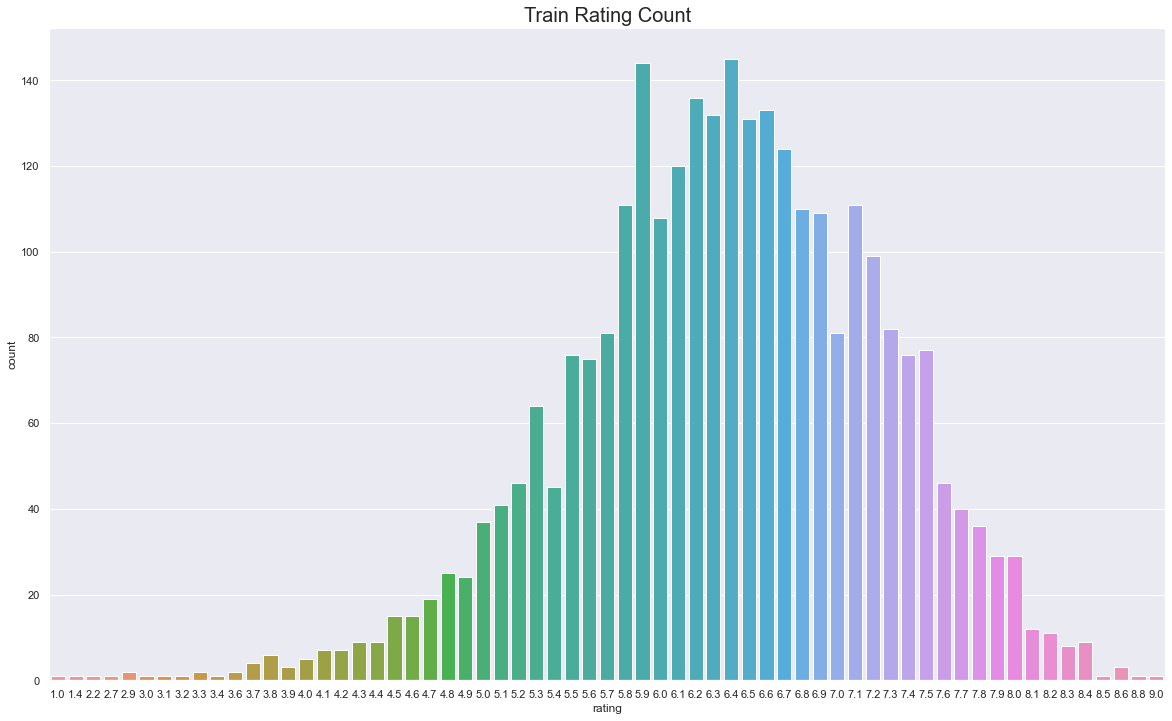

In [123]:
plt.figure(figsize=(20,12))
sns.countplot(df_train['rating'])
plt.title("Train Rating Count",fontsize=20)
plt.show()

It looks like normal distribution. Let`s fill our missing values with median of both features.

In [124]:
df_train['rating'] = df_train['rating'].fillna(df_train['rating'].median())
df_train['totalVotes'] = df_train['totalVotes'].fillna(df_train['totalVotes'].median())

C:\Anaconda\envs\p3.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



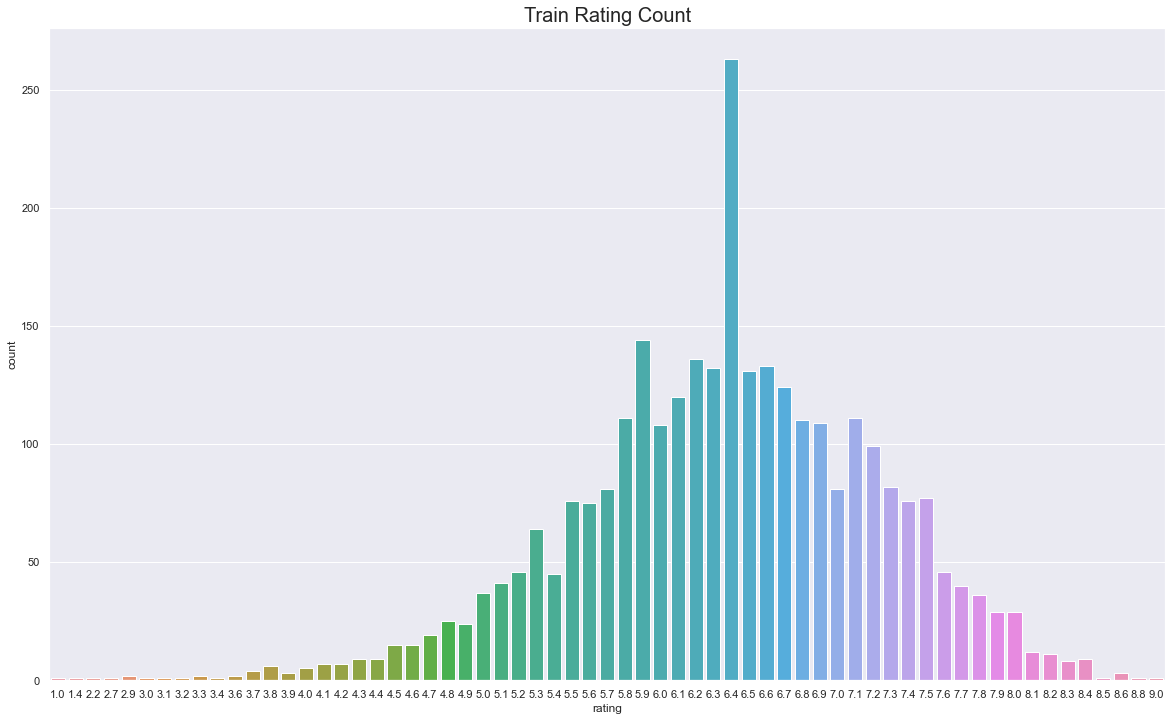

In [125]:
plt.figure(figsize=(20,12))
sns.countplot(df_train['rating'])
plt.title("Train Rating Count",fontsize=20)
plt.show()

C:\Anaconda\envs\p3.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



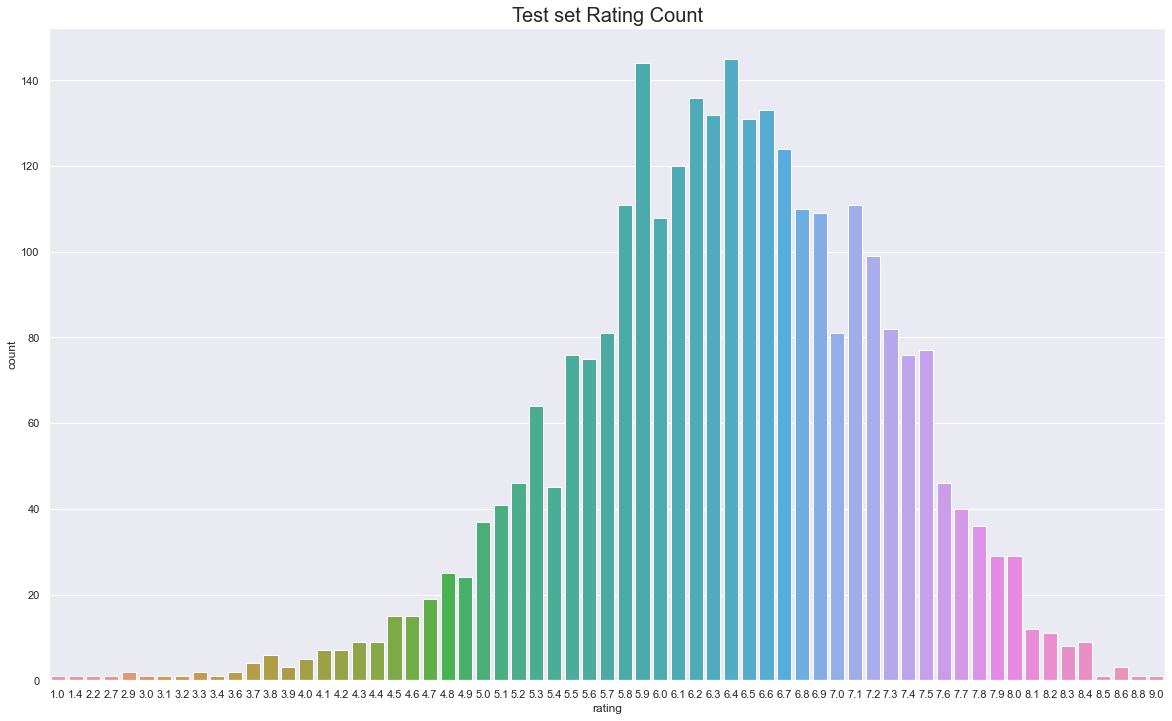

In [126]:
plt.figure(figsize=(20,12))
sns.countplot(df_test['rating'].sort_values())
plt.title("Test set Rating Count",fontsize=20)
plt.show()

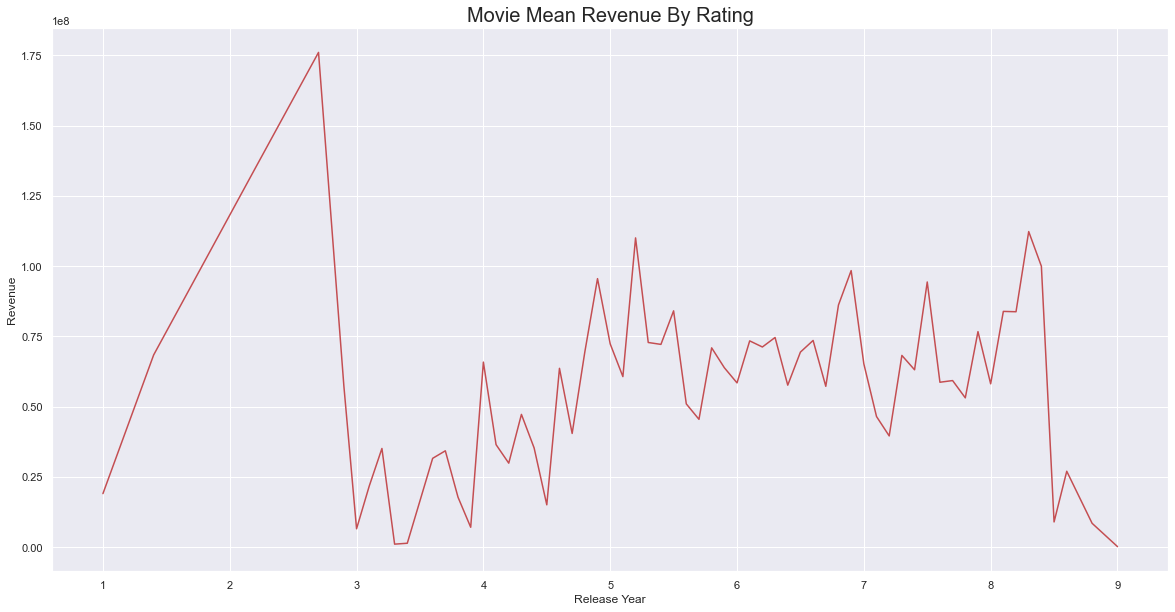

In [127]:
df_train.groupby("rating")["revenue"].aggregate('mean').plot(figsize=(20,10),color="r")
plt.xlabel("Release Year")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Rating",fontsize=20)
plt.show()

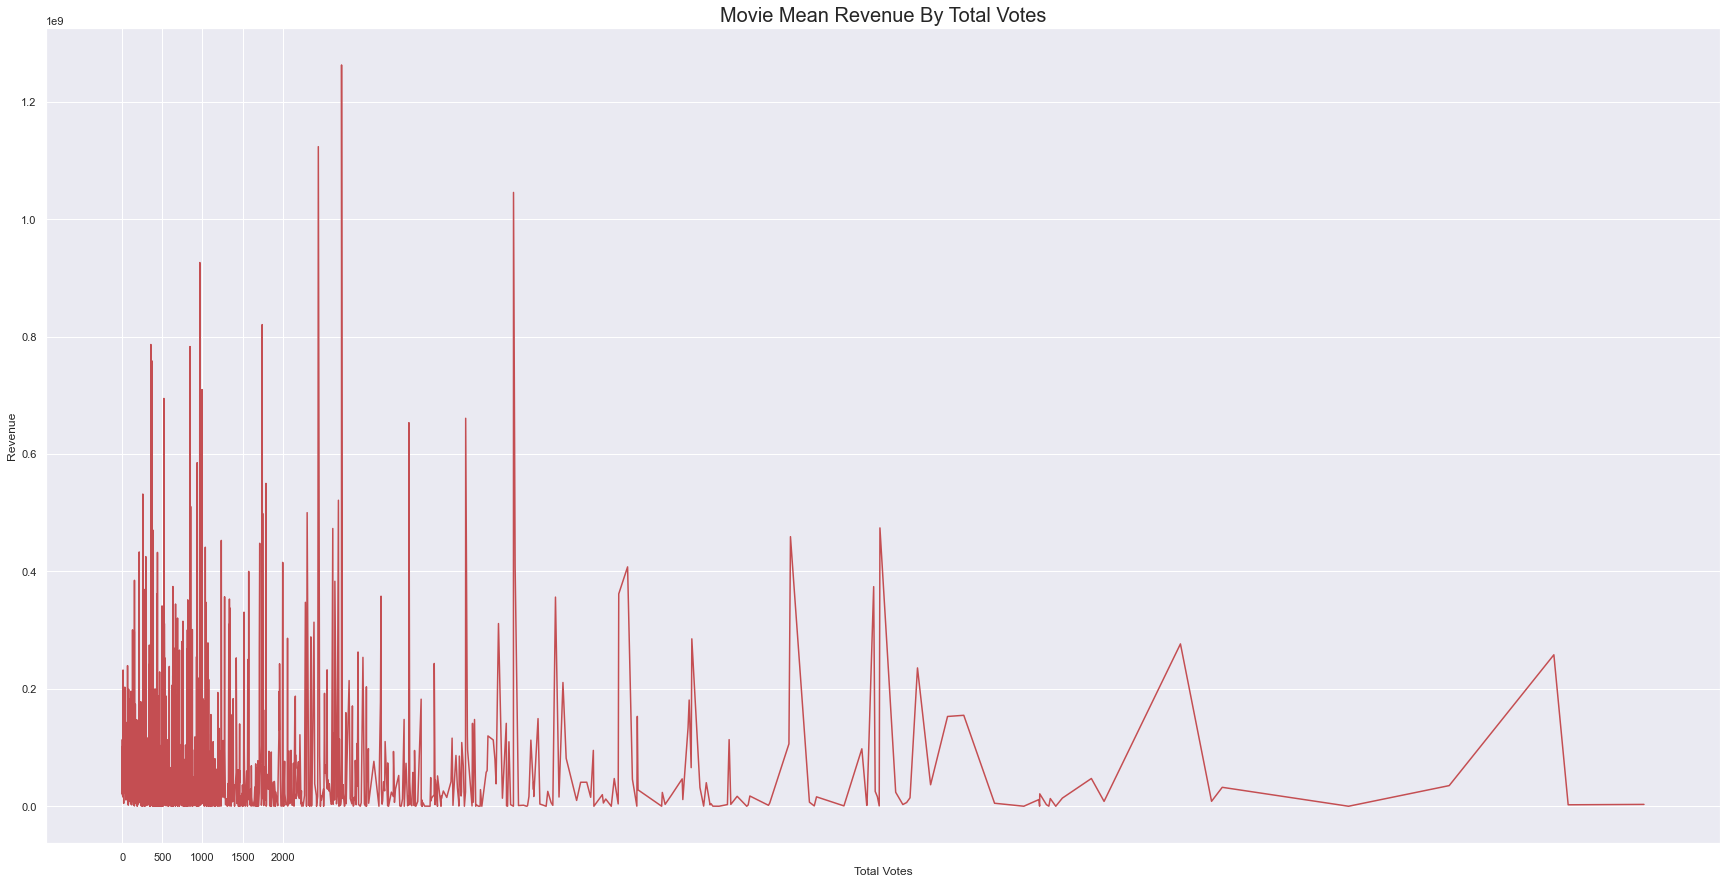

In [128]:
df_train.groupby("totalVotes")["revenue"].aggregate('mean').plot(figsize=(30,15),color="r")
plt.xticks(np.arange(0,2500,500))
plt.xlabel("Total Votes")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Total Votes",fontsize=20)
plt.show()

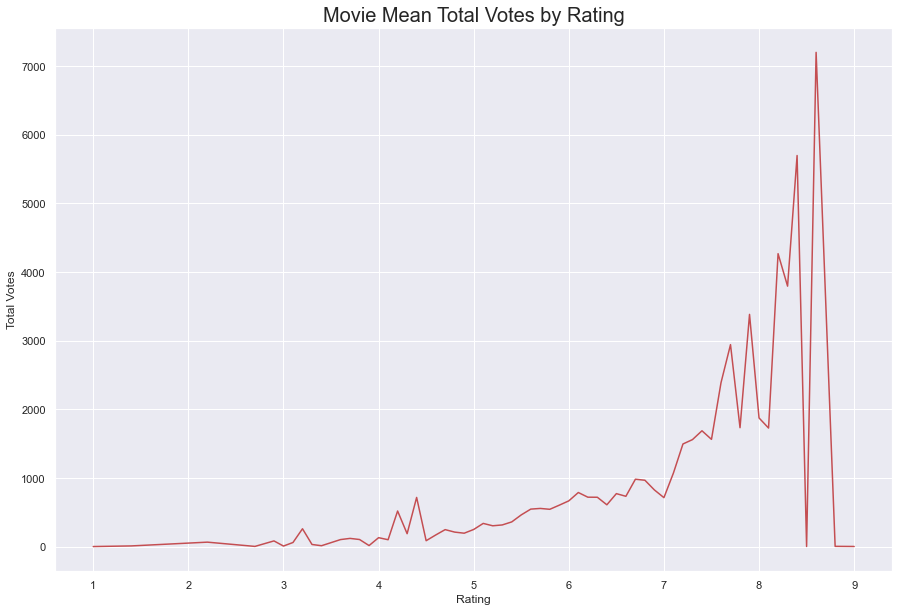

In [129]:
df_train.groupby("rating")["totalVotes"].aggregate('mean').plot(figsize=(15,10),color="r")
plt.xlabel("Rating")
plt.ylabel("Total Votes")
plt.title("Movie Mean Total Votes by Rating",fontsize=20)
plt.show()

## Feature engineering

In [130]:
df_train = df_train.drop(['belongs_to_collection'], axis=1)
df_test = df_test.drop(['belongs_to_collection'], axis=1)

In [131]:
df_train = df_train.drop(['homepage', 'imdb_id', 'poster_path', 'status', 'imdb_id'], axis=1)
df_test = df_test.drop(['homepage', 'imdb_id', 'poster_path', 'status'], axis=1)

In [132]:
for col in df_train.columns:
    if df_train[col].nunique() == 1:
        print(col)
        df_train = df_train.drop([col], axis=1)
        df_test = df_test.drop([col], axis=1)

spoken_languages_
cast_character_


In [133]:
# df_train = df_train.drop(['all_cast'], axis=1)
# df_test = df_test.drop(['all_cast'], axis=1)

In [134]:
for col in ['original_language', 'all_genres']:
    le = LabelEncoder()
    le.fit(list(df_train[col].fillna('')) + list(df_test[col].fillna('')))
    df_train[col] = le.transform(df_train[col].fillna('').astype(str))
    df_test[col] = le.transform(df_test[col].fillna('').astype(str))

In [135]:
df_train_texts = df_train[['title', 'tagline', 'overview', 'original_title']]
df_test_texts = df_test[['title', 'tagline', 'overview', 'original_title']]

In [136]:
for col in ['title', 'tagline', 'overview', 'original_title']:
    df_train['len_' + col] = df_train[col].fillna('').apply(lambda x: len(str(x)))
    df_train['words_' + col] = df_train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    df_train = df_train.drop(col, axis=1)
    df_test['len_' + col] = df_test[col].fillna('').apply(lambda x: len(str(x)))
    df_test['words_' + col] = df_test[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    df_test = df_test.drop(col, axis=1)

Doing some manual assignment, data is obtained from Google

In [137]:
df_train.loc[df_train['id'] == 16, 'revenue'] = 192864  # Skinning
df_train.loc[df_train['id'] == 90, 'budget'] = 30000000  # Sommersby
df_train.loc[df_train['id'] == 118, 'budget'] = 60000000  # Wild Hogs
df_train.loc[df_train['id'] == 149, 'budget'] = 18000000  # Beethoven
df_train.loc[df_train['id'] == 313, 'revenue'] = 12000000  # The Cookout
df_train.loc[df_train['id'] == 451, 'revenue'] = 12000000  # Chasing Liberty
df_train.loc[df_train['id'] == 464, 'budget'] = 20000000  # Parenthood
df_train.loc[df_train['id'] == 470, 'budget'] = 13000000  # The Karate Kid, Part II
df_train.loc[df_train['id'] == 513, 'budget'] = 930000  # From Prada to Nada
df_train.loc[df_train['id'] == 797, 'budget'] = 8000000  # Welcome to Dongmakgol
df_train.loc[df_train['id'] == 819, 'budget'] = 90000000  # Alvin and the Chipmunks: The Road Chip
df_train.loc[df_train['id'] == 850, 'budget'] = 90000000  # Modern Times
df_train.loc[df_train['id'] == 1007, 'budget'] = 2  # Zyzzyx Road
df_train.loc[df_train['id'] == 1112, 'budget'] = 7500000  # An Officer and a Gentleman
df_train.loc[df_train['id'] == 1131, 'budget'] = 4300000  # Smokey and the Bandit
df_train.loc[df_train['id'] == 1359, 'budget'] = 10000000  # Stir Crazy
df_train.loc[df_train['id'] == 1542, 'budget'] = 1  # All at Once
df_train.loc[df_train['id'] == 1570, 'budget'] = 15800000  # Crocodile Dundee II
df_train.loc[df_train['id'] == 1571, 'budget'] = 4000000  # Lady and the Tramp
df_train.loc[df_train['id'] == 1714, 'budget'] = 46000000  # The Recruit
df_train.loc[df_train['id'] == 1721, 'budget'] = 17500000  # Cocoon
df_train.loc[df_train['id'] == 1865, 'revenue'] = 25000000  # Scooby-Doo 2: Monsters Unleashed
df_train.loc[df_train['id'] == 1885, 'budget'] = 12  # In the Cut
df_train.loc[df_train['id'] == 2091, 'budget'] = 10  # Deadfall
df_train.loc[df_train['id'] == 2268, 'budget'] = 17500000  # Madea Goes to Jail budget
df_train.loc[df_train['id'] == 2491, 'budget'] = 6  # Never Talk to Strangers
df_train.loc[df_train['id'] == 2602, 'budget'] = 31000000  # Mr. Holland's Opus
df_train.loc[df_train['id'] == 2612, 'budget'] = 15000000  # Field of Dreams
df_train.loc[df_train['id'] == 2696, 'budget'] = 10000000  # Nurse 3-D
df_train.loc[df_train['id'] == 2801, 'budget'] = 10000000  # Fracture
df_train.loc[df_train['id'] == 335, 'budget'] = 2
df_train.loc[df_train['id'] == 348, 'budget'] = 12
df_train.loc[df_train['id'] == 470, 'budget'] = 13000000
df_train.loc[df_train['id'] == 513, 'budget'] = 1100000
df_train.loc[df_train['id'] == 640, 'budget'] = 6
df_train.loc[df_train['id'] == 696, 'budget'] = 1
df_train.loc[df_train['id'] == 797, 'budget'] = 8000000
df_train.loc[df_train['id'] == 850, 'budget'] = 1500000
df_train.loc[df_train['id'] == 1199, 'budget'] = 5
df_train.loc[df_train['id'] == 1282, 'budget'] = 9  # Death at a Funeral
df_train.loc[df_train['id'] == 1347, 'budget'] = 1
df_train.loc[df_train['id'] == 1755, 'budget'] = 2
df_train.loc[df_train['id'] == 1801, 'budget'] = 5
df_train.loc[df_train['id'] == 1918, 'budget'] = 592
df_train.loc[df_train['id'] == 2033, 'budget'] = 4
df_train.loc[df_train['id'] == 2118, 'budget'] = 344
df_train.loc[df_train['id'] == 2252, 'budget'] = 130
df_train.loc[df_train['id'] == 2256, 'budget'] = 1
df_train.loc[df_train['id'] == 2696, 'budget'] = 10000000

In [138]:
df_test.loc[df_test['id'] == 6733, 'budget'] = 5000000
df_test.loc[df_test['id'] == 3889, 'budget'] = 15000000
df_test.loc[df_test['id'] == 6683, 'budget'] = 50000000
df_test.loc[df_test['id'] == 5704, 'budget'] = 4300000
df_test.loc[df_test['id'] == 6109, 'budget'] = 281756
df_test.loc[df_test['id'] == 7242, 'budget'] = 10000000
df_test.loc[df_test['id'] == 7021, 'budget'] = 17540562  # Two Is a Family
df_test.loc[df_test['id'] == 5591, 'budget'] = 4000000  # The Orphanage
df_test.loc[df_test['id'] == 4282, 'budget'] = 20000000  # Big Top Pee-wee
df_test.loc[df_test['id'] == 3033, 'budget'] = 250
df_test.loc[df_test['id'] == 3051, 'budget'] = 50
df_test.loc[df_test['id'] == 3084, 'budget'] = 337
df_test.loc[df_test['id'] == 3224, 'budget'] = 4
df_test.loc[df_test['id'] == 3594, 'budget'] = 25
df_test.loc[df_test['id'] == 3619, 'budget'] = 500
df_test.loc[df_test['id'] == 3831, 'budget'] = 3
df_test.loc[df_test['id'] == 3935, 'budget'] = 500
df_test.loc[df_test['id'] == 4049, 'budget'] = 995946
df_test.loc[df_test['id'] == 4424, 'budget'] = 3
df_test.loc[df_test['id'] == 4460, 'budget'] = 8
df_test.loc[df_test['id'] == 4555, 'budget'] = 1200000
df_test.loc[df_test['id'] == 4624, 'budget'] = 30
df_test.loc[df_test['id'] == 4645, 'budget'] = 500
df_test.loc[df_test['id'] == 4709, 'budget'] = 450
df_test.loc[df_test['id'] == 4839, 'budget'] = 7
df_test.loc[df_test['id'] == 3125, 'budget'] = 25
df_test.loc[df_test['id'] == 3142, 'budget'] = 1
df_test.loc[df_test['id'] == 3201, 'budget'] = 450
df_test.loc[df_test['id'] == 3222, 'budget'] = 6
df_test.loc[df_test['id'] == 3545, 'budget'] = 38
df_test.loc[df_test['id'] == 3670, 'budget'] = 18
df_test.loc[df_test['id'] == 3792, 'budget'] = 19
df_test.loc[df_test['id'] == 3881, 'budget'] = 7
df_test.loc[df_test['id'] == 3969, 'budget'] = 400
df_test.loc[df_test['id'] == 4196, 'budget'] = 6
df_test.loc[df_test['id'] == 4221, 'budget'] = 11
df_test.loc[df_test['id'] == 4222, 'budget'] = 500
df_test.loc[df_test['id'] == 4285, 'budget'] = 11
df_test.loc[df_test['id'] == 4319, 'budget'] = 1
df_test.loc[df_test['id'] == 4639, 'budget'] = 10
df_test.loc[df_test['id'] == 4719, 'budget'] = 45
df_test.loc[df_test['id'] == 4822, 'budget'] = 22
df_test.loc[df_test['id'] == 4829, 'budget'] = 20
df_test.loc[df_test['id'] == 4969, 'budget'] = 20
df_test.loc[df_test['id'] == 5021, 'budget'] = 40
df_test.loc[df_test['id'] == 5035, 'budget'] = 1
df_test.loc[df_test['id'] == 5063, 'budget'] = 14
df_test.loc[df_test['id'] == 5119, 'budget'] = 2
df_test.loc[df_test['id'] == 5214, 'budget'] = 30
df_test.loc[df_test['id'] == 5221, 'budget'] = 50
df_test.loc[df_test['id'] == 4903, 'budget'] = 15
df_test.loc[df_test['id'] == 4983, 'budget'] = 3
df_test.loc[df_test['id'] == 5102, 'budget'] = 28
df_test.loc[df_test['id'] == 5217, 'budget'] = 75
df_test.loc[df_test['id'] == 5224, 'budget'] = 3
df_test.loc[df_test['id'] == 5469, 'budget'] = 20
df_test.loc[df_test['id'] == 5840, 'budget'] = 1
df_test.loc[df_test['id'] == 5960, 'budget'] = 30
df_test.loc[df_test['id'] == 6506, 'budget'] = 11
df_test.loc[df_test['id'] == 6553, 'budget'] = 280
df_test.loc[df_test['id'] == 6561, 'budget'] = 7
df_test.loc[df_test['id'] == 6582, 'budget'] = 218
df_test.loc[df_test['id'] == 6638, 'budget'] = 5
df_test.loc[df_test['id'] == 6749, 'budget'] = 8
df_test.loc[df_test['id'] == 6759, 'budget'] = 50
df_test.loc[df_test['id'] == 6856, 'budget'] = 10
df_test.loc[df_test['id'] == 6858, 'budget'] = 100
df_test.loc[df_test['id'] == 6876, 'budget'] = 250
df_test.loc[df_test['id'] == 6972, 'budget'] = 1
df_test.loc[df_test['id'] == 7079, 'budget'] = 8000000
df_test.loc[df_test['id'] == 7150, 'budget'] = 118
df_test.loc[df_test['id'] == 6506, 'budget'] = 118
df_test.loc[df_test['id'] == 7225, 'budget'] = 6
df_test.loc[df_test['id'] == 7231, 'budget'] = 85
df_test.loc[df_test['id'] == 5222, 'budget'] = 5
df_test.loc[df_test['id'] == 5322, 'budget'] = 90
df_test.loc[df_test['id'] == 5350, 'budget'] = 70
df_test.loc[df_test['id'] == 5378, 'budget'] = 10
df_test.loc[df_test['id'] == 5545, 'budget'] = 80
df_test.loc[df_test['id'] == 5810, 'budget'] = 8
df_test.loc[df_test['id'] == 5926, 'budget'] = 300
df_test.loc[df_test['id'] == 5927, 'budget'] = 4
df_test.loc[df_test['id'] == 5986, 'budget'] = 1
df_test.loc[df_test['id'] == 6053, 'budget'] = 20
df_test.loc[df_test['id'] == 6104, 'budget'] = 1
df_test.loc[df_test['id'] == 6130, 'budget'] = 30
df_test.loc[df_test['id'] == 6301, 'budget'] = 150
df_test.loc[df_test['id'] == 6276, 'budget'] = 100
df_test.loc[df_test['id'] == 6473, 'budget'] = 100
df_test.loc[df_test['id'] == 6842, 'budget'] = 30

## TRAIN

In [139]:
not_needed_col_test = []
for column in list(df_test.columns):
    if column not in list(df_train.columns):
        not_needed_col_test.append(column)


In [140]:
not_needed_col = []
for column in list(df_train.columns):
    if column not in list(df_test.columns):
        not_needed_col.append(column)


In [141]:
df_train = df_train.drop(columns=['release_date'])
df_test = df_test.drop(columns=['release_date'])

In [142]:
df_train.shape, df_test.shape

((3000, 231), (4398, 225))

In [143]:
df_train

,id,budget,original_language,popularity,runtime,revenue,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_companies,production_companies_Warner Bros.,production_companies_Universal Pictures,production_companies_Paramount Pictures,production_companies_Twentieth Century Fox Film Corporation,production_companies_Columbia Pictures,production_companies_Metro-Goldwyn-Mayer (MGM),production_companies_New Line Cinema,production_companies_Touchstone Pictures,production_companies_Walt Disney Pictures,production_companies_Columbia Pictures Corporation,production_companies_TriStar Pictures,production_companies_Relativity Media,production_companies_Canal+,production_companies_United Artists,production_companies_Miramax Films,production_companies_Village Roadshow Pictures,production_companies_Regency Enterprises,production_companies_BBC Films,production_companies_Dune Entertainment,production_companies_Working Title Films,production_companies_Fox Searchlight Pictures,production_companies_StudioCanal,production_companies_Lionsgate,production_companies_DreamWorks SKG,production_companies_Fox 2000 Pictures,production_companies_Summit Entertainment,production_companies_Hollywood Pictures,production_companies_Orion Pictures,production_companies_Amblin Entertainment,production_companies_Dimension Films,num_countries,production_countries_United States of America,production_countries_United Kingdom,production_countries_France,production_countries_Germany,production_countries_Canada,production_countries_India,production_countries_Italy,production_countries_Japan,production_countries_Australia,production_countries_Russia,production_countries_Spain,production_countries_China,production_countries_Hong Kong,production_countries_Ireland,production_countries_Belgium,production_countries_South Korea,production_countries_Mexico,production_countries_Sweden,production_countries_New Zealand,production_countries_Netherlands,production_countries_Czech Republic,production_countries_Denmark,production_countries_Brazil,production_countries_Luxembourg,production_countries_South Africa,num_languages,spoken_languages_English,spoken_languages_Français,spoken_languages_Español,spoken_languages_Deutsch,spoken_languages_Pусский,spoken_languages_Italiano,spoken_languages_日本語,spoken_languages_普通话,spoken_languages_हिन्दी,spoken_languages_Português,spoken_languages_العربية,spoken_languages_한국어/조선말,spoken_languages_广州话 / 廣州話,spoken_languages_தமிழ்,spoken_languages_Polski,spoken_languages_Magyar,spoken_languages_Latin,spoken_languages_svenska,spoken_languages_ภาษาไทย,spoken_languages_Český,spoken_languages_עִבְרִית,spoken_languages_ελληνικά,spoken_languages_Türkçe,spoken_languages_Dansk,num_Keywords,Keywords_woman director,Keywords_independent film,Keywords_duringcreditsstinger,Keywords_murder,Keywords_based on novel,Keywords_violence,Keywords_sport,Keywords_biography,Keywords_aftercreditsstinger,Keywords_dystopia,Keywords_revenge,Keywords_friendship,Keywords_sex,Keywords_suspense,Keywords_sequel,Keywords_love,Keywords_police,Keywords_teenager,Keywords_nudity,Keywords_female nudity,Keywords_drug,Keywords_prison,Keywords_musical,Keywords_high school,Keywords_los angeles,Keywords_new york,Keywords_family,Keywords_father son relationship,Keywords_kidnapping,Keywords_investigation,num_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,genders_0_cast,genders_1_cast,genders_2_cast,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice)

In [144]:
not_needed_col = not_needed_col[1:]

In [145]:
for column in not_needed_col:
    df_train = df_train.drop(columns=column)
for column in not_needed_col_test:
    df_test = df_test.drop(columns=column)

In [146]:
X = df_train.drop(['id', 'revenue'], axis=1)
y = np.log1p(df_train['revenue'])
X_test = df_test.drop(['id'], axis=1)

In [147]:
mask = ~X.isna().any(axis=1)
X = X[mask]
y = y[mask]

In [148]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

## Linear Regression

In [149]:
def train_reg(X, y, folds):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = []
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred_valid = model.predict(X_valid)
        
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        feature_importance.append(model.coef_)
    return scores, model, feature_importance


reg_scores, reg_model, reg_fi = train_reg(X.to_numpy(), y.to_numpy(), folds=folds)

Fold 0 started at Mon Mar 14 18:30:44 2022
Fold 1 started at Mon Mar 14 18:30:44 2022
Fold 2 started at Mon Mar 14 18:30:44 2022
Fold 3 started at Mon Mar 14 18:30:44 2022
Fold 4 started at Mon Mar 14 18:30:44 2022
Fold 5 started at Mon Mar 14 18:30:44 2022
Fold 6 started at Mon Mar 14 18:30:44 2022
Fold 7 started at Mon Mar 14 18:30:44 2022
Fold 8 started at Mon Mar 14 18:30:44 2022
Fold 9 started at Mon Mar 14 18:30:44 2022


In [150]:
print(f'Linear regression score : {np.mean(reg_scores)}')

Linear regression score : 2.391655816985744


<BarContainer object of 15 artists>

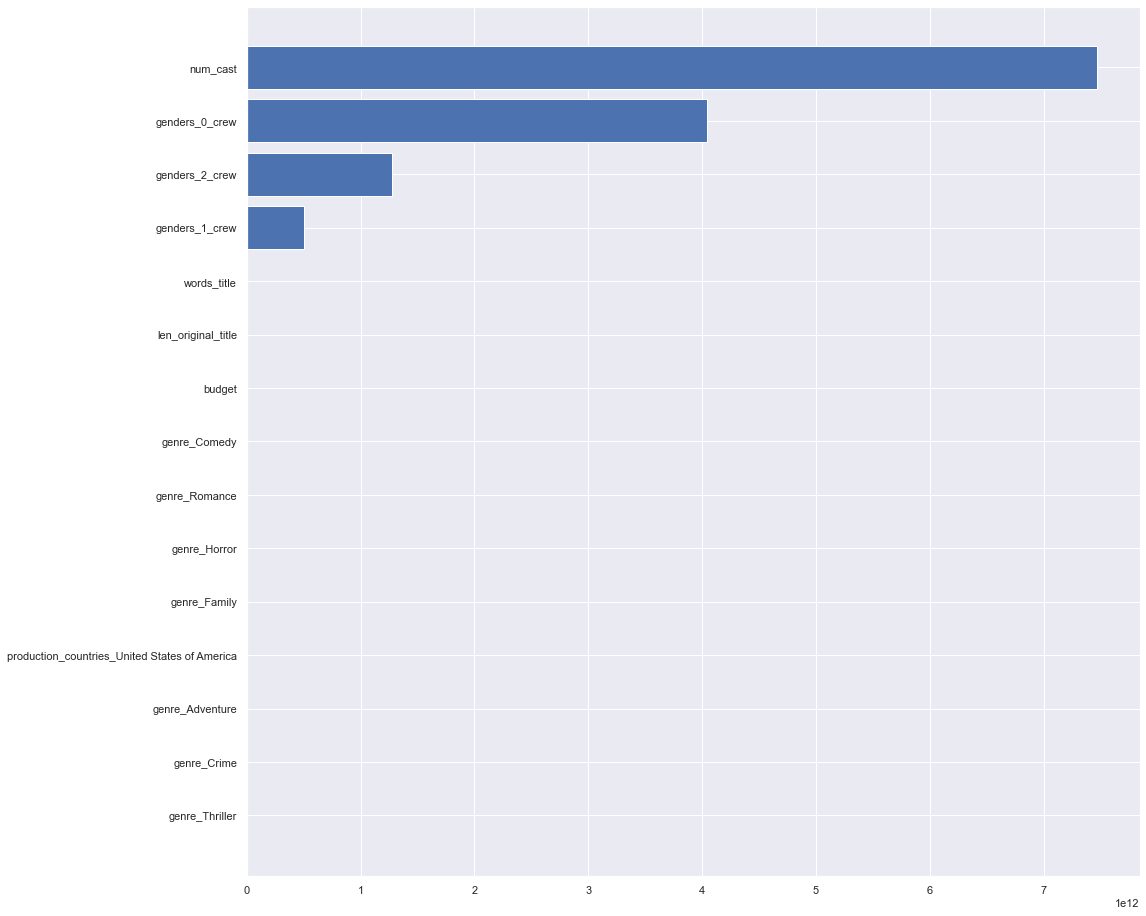

In [151]:
reg_fim = np.mean(reg_fi, axis=0)
reg_best_f = np.argsort(reg_fim)[-15:]

plt.figure(figsize=(16,16))
plt.barh(X.columns[reg_best_f], reg_fim[reg_best_f])

## KNN

In [152]:
from sklearn.neighbors import KNeighborsRegressor

In [153]:
def train_knn(X, y, folds):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)

        model = KNeighborsRegressor()
        model.fit(X_train, y_train)

        y_pred_valid = model.predict(X_valid)
        
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
    return scores, model


knn_scores, knn_model = train_knn(X.to_numpy(), y.to_numpy(), folds=folds)

Fold 0 started at Mon Mar 14 18:30:45 2022
Fold 1 started at Mon Mar 14 18:30:45 2022
Fold 2 started at Mon Mar 14 18:30:45 2022
Fold 3 started at Mon Mar 14 18:30:45 2022
Fold 4 started at Mon Mar 14 18:30:45 2022
Fold 5 started at Mon Mar 14 18:30:45 2022
Fold 6 started at Mon Mar 14 18:30:45 2022
Fold 7 started at Mon Mar 14 18:30:45 2022
Fold 8 started at Mon Mar 14 18:30:45 2022
Fold 9 started at Mon Mar 14 18:30:45 2022


In [154]:
print(f'KNN regression score : {np.mean(knn_scores)}')

KNN regression score : 2.825097858438375


## Catboost

In [155]:
def train_model(X, y, folds, params=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = []
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        
        model = CatBoostRegressor(eval_metric='RMSE', **params)
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

        y_pred_valid = model.predict(X_valid)
        y_pred = model.predict(X_test)
        
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        feature_importance.append(model.feature_importances_)
    return scores, model, feature_importance

In [156]:
params = {
    #'num_leaves': 30,
    #'min_data_in_leaf': 10,
    #'objective': 'regression',
    #'max_depth': 5,
    #'learning_rate': 0.01,
    'iterations' : 10,
}
cb_scores, cb_model, cb_fi = train_model(X.to_numpy(), y.to_numpy(), folds=folds, params=params)

Fold 0 started at Mon Mar 14 18:30:46 2022
Fold 1 started at Mon Mar 14 18:30:46 2022
Fold 2 started at Mon Mar 14 18:30:46 2022
Fold 3 started at Mon Mar 14 18:30:47 2022
Fold 4 started at Mon Mar 14 18:30:47 2022
Fold 5 started at Mon Mar 14 18:30:47 2022
Fold 6 started at Mon Mar 14 18:30:47 2022
Fold 7 started at Mon Mar 14 18:30:48 2022
Fold 8 started at Mon Mar 14 18:30:48 2022
Fold 9 started at Mon Mar 14 18:30:48 2022


In [157]:
print(f'Catboost  score : {np.mean(cb_scores)}')

Catboost  score : 2.1795947419346504


In [158]:
cb_fi

[array([4.80737095e+01, 0.00000000e+00, 1.39708677e+01, 4.82485548e+00,
        0.00000000e+00, 3.15637510e+00, 2.18144024e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.25332897e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.18615363e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.63470812e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

<BarContainer object of 15 artists>

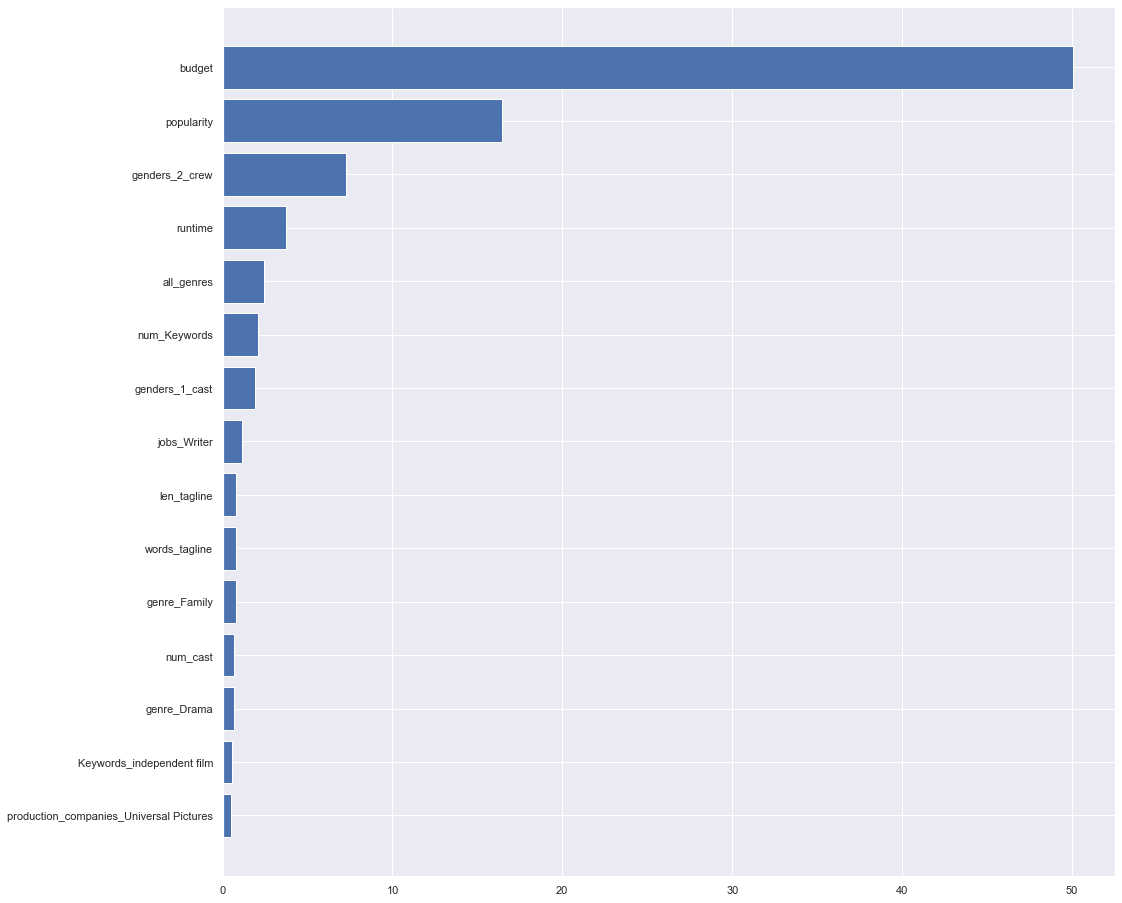

In [159]:
cb_fim = np.mean(cb_fi, axis=0)
cb_best_f = np.argsort(cb_fim)[-15:]

plt.figure(figsize=(16,16))
plt.barh(X.columns[cb_best_f], cb_fim[cb_best_f])

In [160]:
df_train.columns

Index(['id', 'budget', 'original_language', 'popularity', 'runtime', 'revenue',
       'num_genres', 'all_genres', 'genre_Drama', 'genre_Comedy',
       ...
       'rating', 'totalVotes', 'len_title', 'words_title', 'len_tagline',
       'words_tagline', 'len_overview', 'words_overview', 'len_original_title',
       'words_original_title'],
      dtype='object', length=206)

In [161]:
def train_model(X, y, folds, params=None):
    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = []
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
   

        model = CatBoostRegressor(eval_metric='RMSE', **params)
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

        y_pred_valid = model.predict(X_valid)
        y_pred = model.predict(X_test)
        
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        feature_importance.append(model.feature_importances_)
        
    
    return scores, model, feature_importance

In [162]:
params = []
for iterations in [100, 300, 500, 1000]:
    for depth in [6, 4]:

        param = {
            'depth' : depth,
            'iterations' : iterations,
            }
        params.append(param)

In [163]:
res = []
for param in params:
    sc, m, fi = train_model(X.to_numpy(), y.to_numpy(), folds=folds, params=param)
    res.append((np.mean(sc), np.mean(fi, axis=0), param, m))

Fold 0 started at Mon Mar 14 18:30:49 2022
Fold 1 started at Mon Mar 14 18:30:50 2022
Fold 2 started at Mon Mar 14 18:30:51 2022
Fold 3 started at Mon Mar 14 18:30:51 2022
Fold 4 started at Mon Mar 14 18:30:52 2022
Fold 5 started at Mon Mar 14 18:30:53 2022
Fold 6 started at Mon Mar 14 18:30:54 2022
Fold 7 started at Mon Mar 14 18:30:55 2022
Fold 8 started at Mon Mar 14 18:30:55 2022
Fold 9 started at Mon Mar 14 18:30:56 2022
Fold 0 started at Mon Mar 14 18:30:57 2022
Fold 1 started at Mon Mar 14 18:30:58 2022
Fold 2 started at Mon Mar 14 18:30:58 2022
Fold 3 started at Mon Mar 14 18:30:59 2022
Fold 4 started at Mon Mar 14 18:30:59 2022
Fold 5 started at Mon Mar 14 18:31:00 2022
Fold 6 started at Mon Mar 14 18:31:00 2022
Fold 7 started at Mon Mar 14 18:31:01 2022
Fold 8 started at Mon Mar 14 18:31:01 2022
Fold 9 started at Mon Mar 14 18:31:02 2022
Fold 0 started at Mon Mar 14 18:31:02 2022
Fold 1 started at Mon Mar 14 18:31:05 2022
Fold 2 started at Mon Mar 14 18:31:07 2022
Fold 3 star

In [164]:
res = sorted(res)

Scores

In [165]:
[e[0] for e in res]

[1.9787947966728467,
 1.9826344499786497,
 1.9845979147752566,
 1.9921235861522235,
 1.9949981400592969,
 1.9952068028486476,
 2.0148706579801963,
 2.0239178878054886]

Top models are close by score but different in parameters. Let's blend them

In [166]:
top_models = [e[-1] for e in res[:3]]

In [167]:
def eval_top_models(X, y, folds, top_models, k):
    top_models = top_models[:k]
    scores = []
    feature_importance = []
    log = []
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        cur_models = [e.copy() for e in top_models]
        for model in cur_models:
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)
            feature_importance.append(model.feature_importances_)
        
        y_pred_valid = np.mean([e.predict(X_valid) for e in cur_models], axis=0)
        log.append((y_pred_valid, y_valid))
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
    
    return np.mean(scores), model, np.mean(feature_importance, axis=0), log

In [168]:
score, m, fi, preds = eval_top_models(X.to_numpy(), y.to_numpy(), folds, top_models, 3)

Fold 0 started at Mon Mar 14 18:33:53 2022
Fold 1 started at Mon Mar 14 18:34:06 2022
Fold 2 started at Mon Mar 14 18:34:18 2022
Fold 3 started at Mon Mar 14 18:34:32 2022
Fold 4 started at Mon Mar 14 18:34:45 2022
Fold 5 started at Mon Mar 14 18:34:57 2022
Fold 6 started at Mon Mar 14 18:35:09 2022
Fold 7 started at Mon Mar 14 18:35:22 2022
Fold 8 started at Mon Mar 14 18:35:33 2022
Fold 9 started at Mon Mar 14 18:35:45 2022


In [169]:
score

1.9712233385813562

So blending slightly improves metric

Let`s look at feature importance

<BarContainer object of 15 artists>

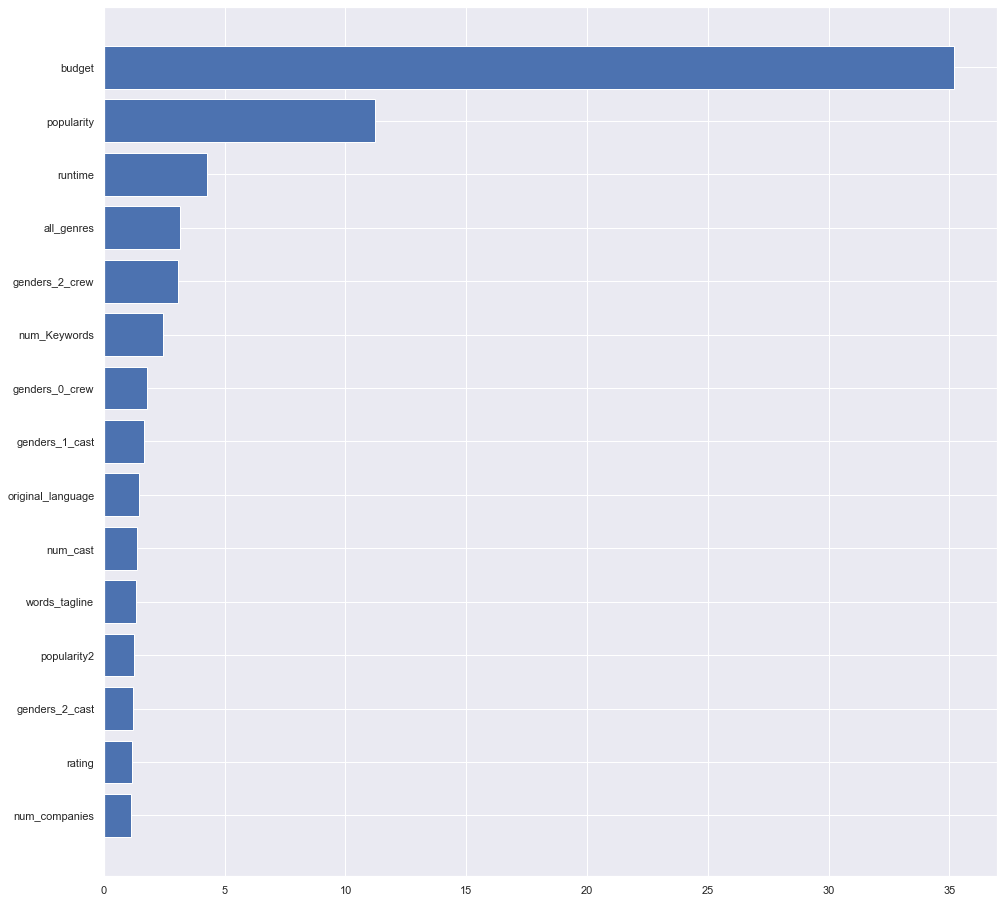

In [170]:
best_f = np.argsort(fi)[-15:]

plt.figure(figsize=(16,16))
plt.barh(X.columns[best_f], fi[best_f])

We can see that budget is, as expected, has the highest value. In the second place goes popularity, which is a feature obtained after release. Runtime and genre are pretty high too, so it`s important to choose it wisely.

In [171]:
p = np.concatenate([e[0] for e in preds], axis=0)
t = np.concatenate([e[1] for e in preds], axis=0)

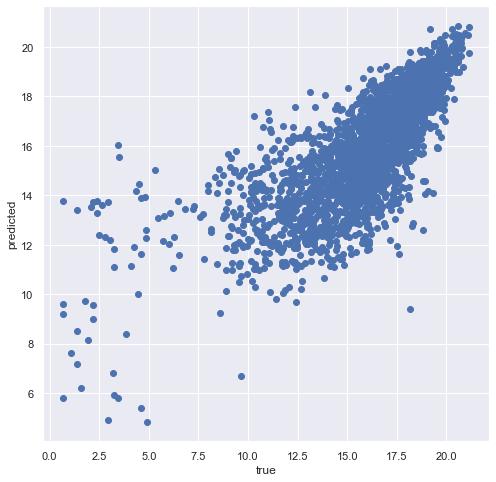

In [172]:
plt.figure(figsize=(8,8))
plt.xlabel('true')
plt.ylabel('predicted')
plt.scatter(t, p)